Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 7

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=7
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=4 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
## DROP_N=675 => 31/10/2021
#
drop_n_dataset_days=675
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
255                                           NaN                 Tunisia   
256                                           NaN                  Turkey   
257                                           NaN           United States   
258                                           NaN                  Uganda   
259                                           NaN                 Ukraine   
260                                           NaN    United Arab Emirates   
261                                      Anguilla          United Kingdom   
262                                       Bermuda          United Kingdom   
263                        British Virgin Islands          United Kingdom   
264                                Cayman Islands          United Kingdom   
265                               Channel Islands          United Kingdom   
266                   Falkland Islands (Malvinas)          United Kingdom   
267                                     Gibraltar          United Kingdom   
268                                      Guernsey          United Kingdom   
269                                   Isle of Man          United Kingdom   
270                                        Jersey          United Kingdom   
271                                    Montserrat          United Kingdom   
272  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
273                      Turks and Caicos Islands          United Kingdom   
274                                           NaN          United Kingdom   
275                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
261                                           NaN                 Tunisia   
262                                           NaN                  Turkey   
263                                           NaN           United States   
264                                           NaN                  Uganda   
265                                           NaN                 Ukraine   
266                                           NaN    United Arab Emirates   
267                                      Anguilla          United Kingdom   
268                                       Bermuda          United Kingdom   
269                        British Virgin Islands          United Kingdom   
270                                Cayman Islands          United Kingdom   
271                               Channel Islands          United Kingdom   
272                   Falkland Islands (Malvinas)          United Kingdom   
273                                     Gibraltar          United Kingdom   
274                                      Guernsey          United Kingdom   
275                                   Isle of Man          United Kingdom   
276                                        Jersey          United Kingdom   
277                                    Montserrat          United Kingdom   
278  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
279                      Turks and Caicos Islands          United Kingdom   
280                                           NaN          United Kingdom   
281                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  8/26/22  8/27/22  8/28/22  \
185        0        0        0        0  ...      307      307      307   
186        0        0        0        0  ...      739      739      739   
187        0        0        0        0  ...      799      801      801   
188        0        0        0        0  ...       16       16       16   
189        0        0        0        0  ...      992      992      992   
190        0        0        0        0  ...     1022     1022     1022   
191        0        0        0        0  ...   329289   329289   329390   
192        0        0        0        0  ...       22       22       22   
193        0        0        0        0  ...    11725    11725    11725   
194        0        0        0        0  ...       61       61       61   

     8/29/22  8/30/22  8/31/22  9/1/22  9/2/22   Population   \
185      308      308      308     308     308       540,544   
186      739      739      739     739     739    20,250,833   
187      801      801      801     801     801       441,543   
188       16       17       17      17      17           NaN   
189      992      992      993     993     993     4,649,658   
190     1022     1023     1023    1023    1023     1,273,985   
191   329390   329390   329390  329536  329572   128,640,794   
192       22       26       26      27      27           NaN   
193    11725    11725    11755   11755   11755     4,035,942   
194       61       61       61      61      61        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 961 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  1/22/20  1/23/20  \
175            NaN     Micronesia   7.425600  150.55080        0        0   
176            NaN        Moldova  47.411600   28.36990        0        0   
177            NaN         Monaco  43.733300    7.41670        0        0   
178            NaN       Mongolia  46.862500  103.84670        0        0   
179            NaN     Montenegro  42.708678   19.37439        0        0   
180            NaN        Morocco  31.791700   -7.09260        0        0   
181            NaN     Mozambique -18.665700   35.52960        0        0   
182            NaN        Namibia -22.957600   18.49040        0        0   
183            NaN          Nepal  28.166700   84.25000        0        0   
184          Aruba    Netherlands  12.521100  -69.96830        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  8/26/22  8/27/22  8/28/22  \
175        0        0        0        0  ...        0        0        0   
176        0        0        0        0  ...        0        0        0   
177        0        0        0        0  ...        0        0        0   
178        0        0        0        0  ...        0        0        0   
179        0        0        0        0  ...        0        0        0   
180        0        0        0        0  ...        0        0        0   
181        0        0        0        0  ...        0        0        0   
182        0        0        0        0  ...        0        0        0   
183        0        0        0        0  ...        0        0        0   
184        0        0        0        0  ...        0        0        0   

     8/29/22  8/30/22  8/31/22  9/1/22  9/2/22   Population   \
175        0        0        0       0       0           NaN   
176        0        0        0       0       0     4,035,942   
177        0        0        0       0       0        39,183   
178        0        0        0       0       0     3,278,290   
179        0        0        0       0       0       622 500   
180        0        0        0       0       0    36,817,128   
181        0        0        0       0       0    31,542,919   
182        0        0        0       0       0     2,540,905   
183        0        0        0       0       0    29,300,000   
184        0        0        0       0       0       116,600   

                region  
175     Micronesia_nan  
176        Moldova_nan  
177         Monaco_nan  
178       Mongolia_nan  
179     Montenegro_nan  
180        Morocco_nan  
181     Mozambique_nan  
182        Namibia_nan  
183          Nepal_nan  
184  Netherlands_Aruba  

[10 rows x 961 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  8/26/22  8/27/22  8/28/22  \
185        0        0        0        0  ...   184788   184788   184788   
186        0        0        0        0  ...    31302    31314    31325   
187        0        0        0        0  ...   113916   113972   113989   
188        0        0        0        0  ...    14506    14506    14506   
189        0        0        0        0  ...    62756    62759    62761   
190        0        0        0        0  ...   254400   254400   254400   
191        0        0        0        0  ...  7001590  7001590  7014510   
192        0        0        0        0  ...     7202     7202     7202   
193        0        0        0        0  ...   569088   569088   569088   
194        0        0        0        0  ...    14363    14363    14363   

     8/29/22  8/30/22  8/31/22   9/1/22   9/2/22   Population   \
185   184856   184856   184856   184856   184856       540,544   
186    31337    31365    31412    31462    31518    20,250,833   
187   114000   114026   114050   114075   114097       441,543   
188    14907    15007    15042    15058    15063           NaN   
189    62761    62762    62765    62768    62769     4,649,658   
190   254400   256452   256452   256452   256452     1,273,985   
191  7014510  7014510  7014510  7032024  7036371   128,640,794   
192     7202     7326     7327     7856     7856           NaN   
193   569088   569088   575052   575052   575052     4,035,942   
194    14363    14375    14379    14384    14398        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 961 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Philippines  12.879721  121.774017   
221            NaN                            Poland  51.919400   19.145100   
222            NaN                          Portugal  39.399900   -8.224500   
223            NaN                             Qatar  25.354800   51.183900   
224            NaN                           Romania  45.943200   24.966800   
225            NaN                            Russia  61.524010  105.318756   
226            NaN                            Rwanda  -1.940300   29.873900   
227            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
228            NaN                       Saint Lucia  13.909400  -60.978900   
229            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   8/26/22  \
220        0        0        0        0        0        0  ...   3869976   
221        0        0        0        0        0        0  ...   6162667   
222        0        0        0        0        0        0  ...   5409185   
223        0        0        0        0        0        0  ...    426586   
224        0        0        0        0        0        0  ...   3206185   
225        0        0        0        0        0        0  ...  19030966   
226        0        0        0        0        0        0  ...    132412   
227        0        0        0        0        0        0  ...      6508   
228        0        0        0        0        0        0  ...     28689   
229        0        0        0        0        0        0  ...      9420   

      8/27/22   8/28/22   8/29/22   8/30/22   8/31/22    9/1/22    9/2/22  \
220   3872405   3874641   3877110   3878734   3880229   3883957   3886395   
221   6166596   6167203   6167759   6173059   6176885   6180224   6183676   
222   5409185   5409185   5413173   5417101   5420140   5420140   5425891   
223    427001    427563    428147    428791    429396    429963    430484   
224   3208903   3210306   3212211   3216257   3219354   3221984   3224382   
225  19077368  19123501  19162384  19198863  19244647  19293663  19343942   
226    132414    132415    132421    132427    132439    132443    132448   
227      6509      6509      6509      6511      6512      6515      6517   
228     28689     28689     28689     28775     28775     28775     28832   
229      9420      9420      9420      9428      9428      9429      9430   

      Population                                 region  
220   104,900,000                       Philippines_nan  
221    37,980,000                            Poland_nan  
222    10,290,000                          Portugal_nan  
223     2,870,256                             Qatar_nan  
224    19,530,000                           Romania_nan  
225   144,500,000                            Russia_nan  
226    12,952,218                            Rwanda_nan  
227        53,673             Saint Kitts and Nevis_nan  
228       184,106                       Saint Lucia_nan  
229       110,940  Saint Vincent and the Grenadines_nan  

[10 rows x 961 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

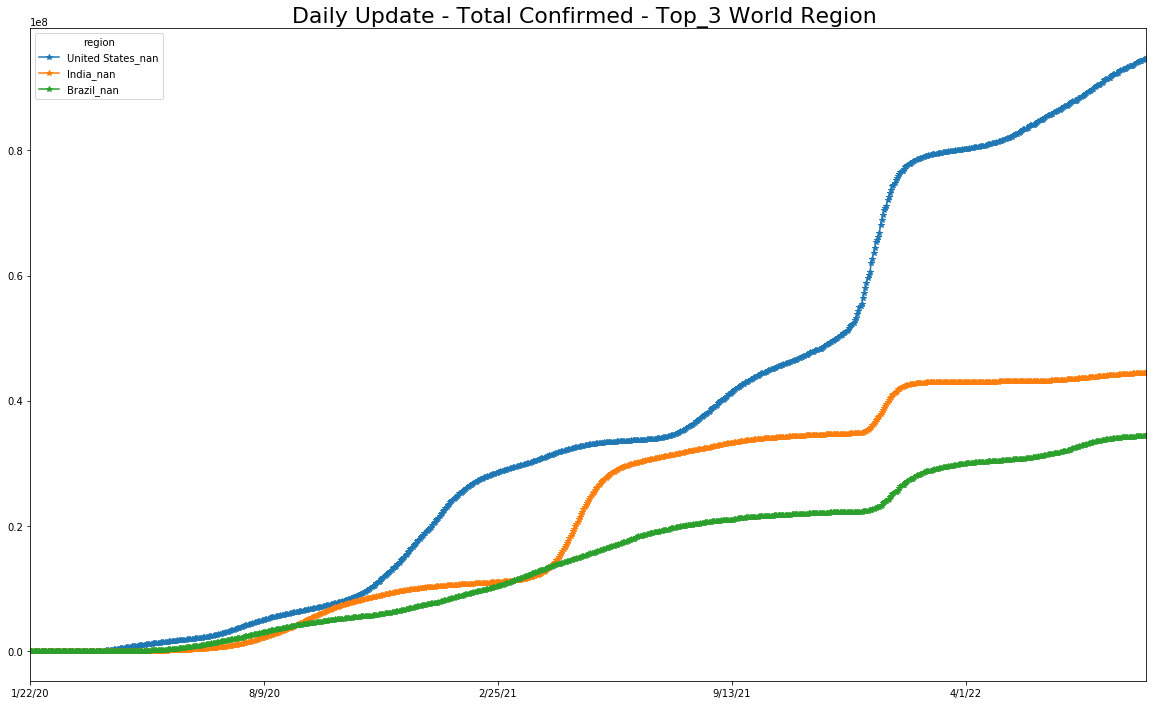

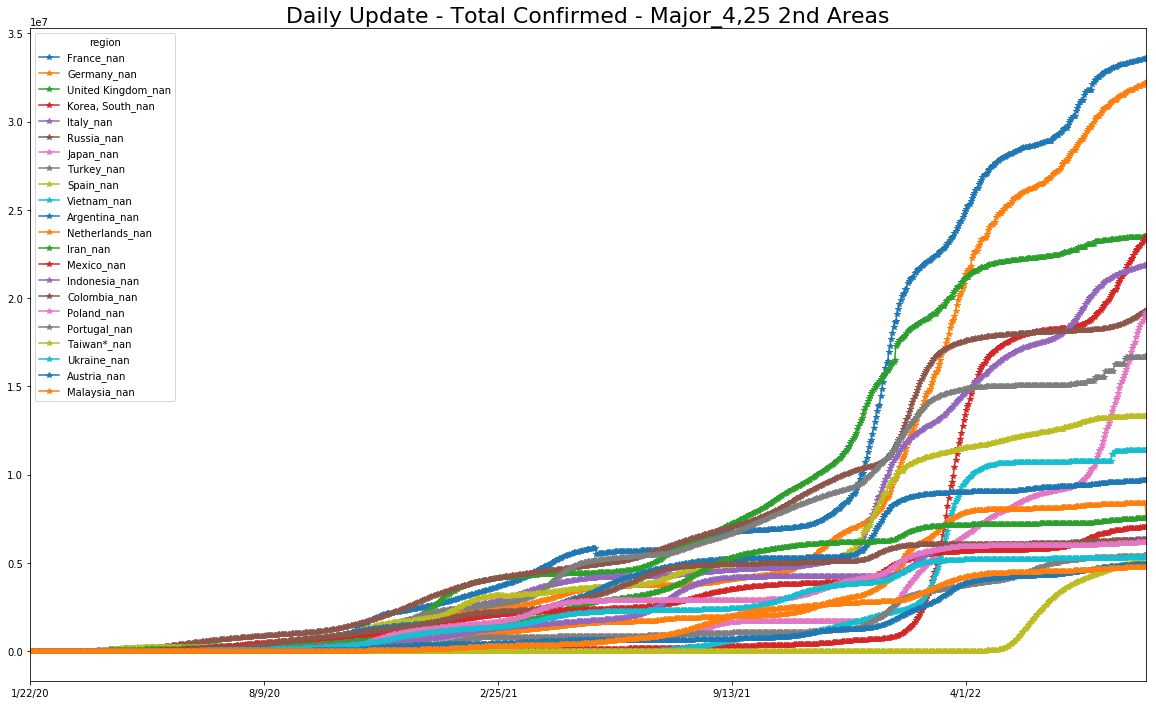

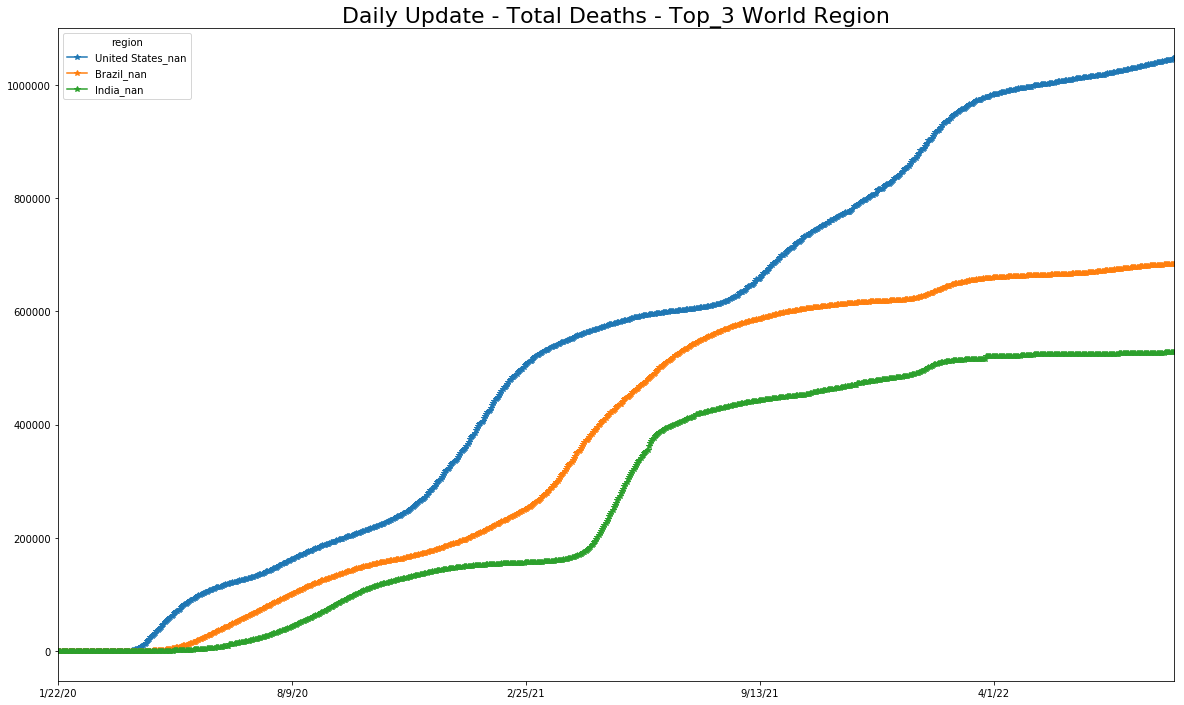

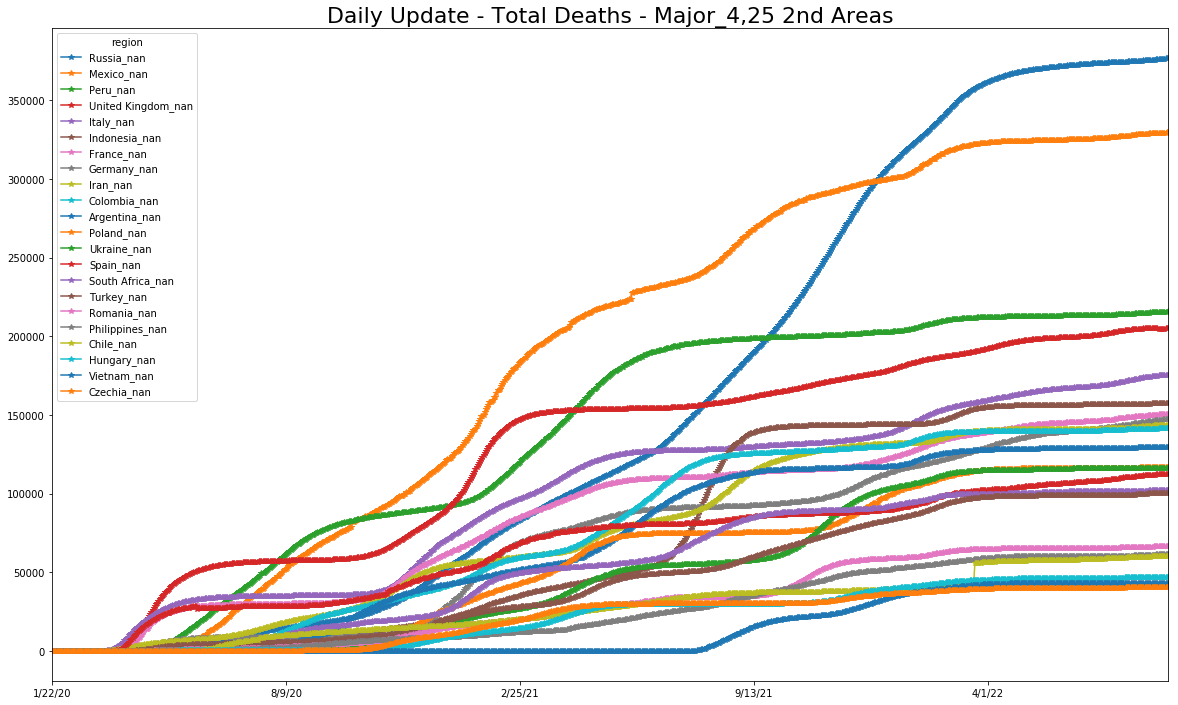

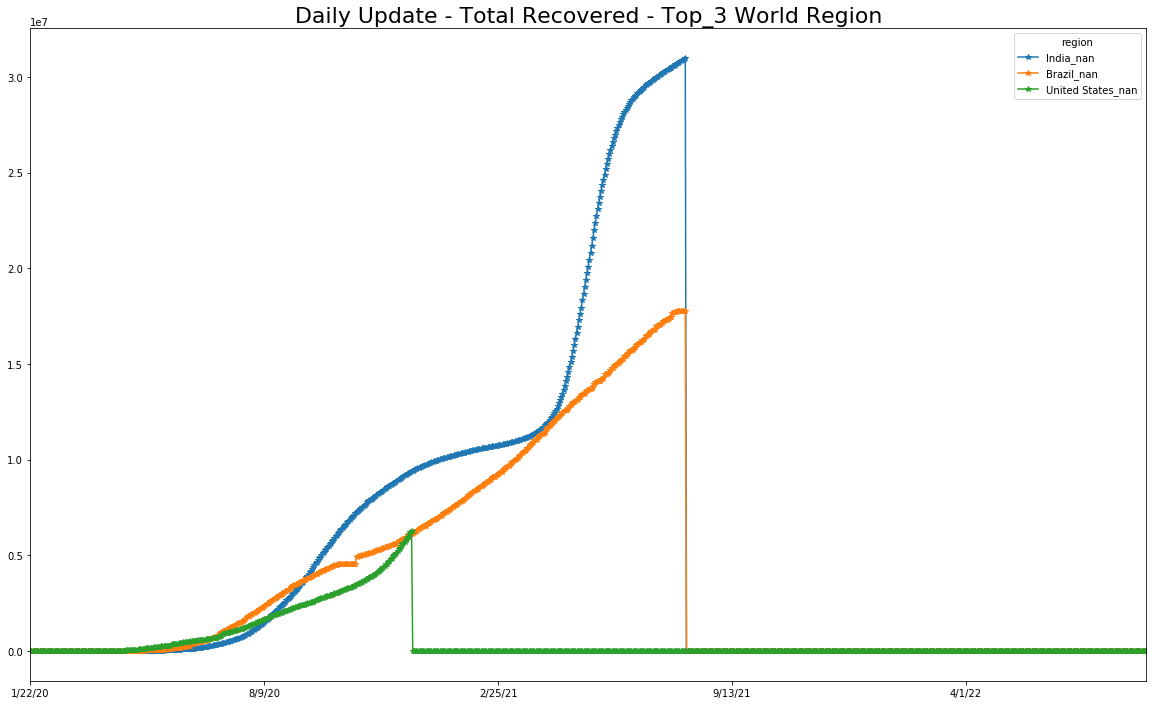

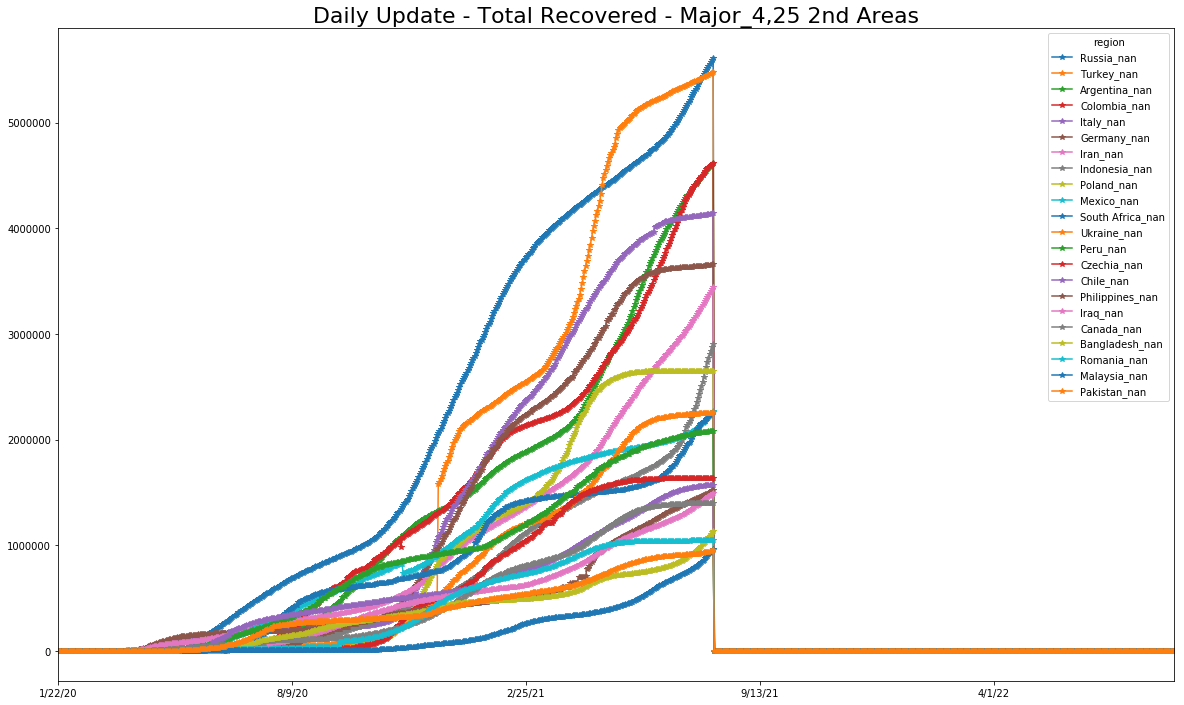

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/09/04


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/27/21           157190       199137       209980        16712       65139   
11/28/21           157218       199555       210152        16712       65144   
11/29/21           157260       199750       210344        16712       65155   

region    Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/27/21               0                     4141        5325560       337522   
11/28/21               0                     4141        5326448       337931   
11/29/21               0                     4141        5328416       338120   

region    Australia_Australian Capital Territory  ...  Uruguay_nan  \
11/27/21                                    2117  ...       399181   
11/28/21                                    2124  ...       399348   
11/29/21                                    2130  ...       399504   

region    Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
11/27/21          192599            6         430046      1197404   
11/28/21          192831            6         430696      1210340   
11/29/21          193065            6         431296      1224110   

region    West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
11/27/21                  459479                         0       9981   
11/28/21                  459479                         0       9987   
11/29/21                  460053                         0       9995   

region    Zambia_nan  Zimbabwe_nan  
11/27/21      210138        133836  
11/28/21      210143        133951  
11/29/21      210150        134226  

[3 rows x 285 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
8/30/22           193004       329017       270272        46027      102636   
8/31/22           193250       329352       270304        46027      102636   
9/1/22            193520       329615       270359        46027      102636   
9/2/22            193520       329862       270405        46027      102636   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
8/30/22              11                     8974        9678225       434398   
8/31/22              11                     8974        9678225       434398   
9/1/22               11                     8974        9678225       434398   
9/2/22               11                     8974        9678225       434398   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
8/30/22                                  202543  ...       979160   
8/31/22                                  202737  ...       979160   
9/1/22                                   202895  ...       979160   
9/2/22                                   202895  ...       979160   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
8/30/22          243784        11793         542281     11408952   
8/31/22          243801        11815         542508     11411679   
9/1/22           243815        11825         542508     11414359   
9/2/22           243830        11836         542508     11415907   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
8/30/22                  701739                       535      11926   
8/31/22                  702332                       535      11926   
9/1/22                   702332                       535      11926   
9/2/22                   702332                       535      11926   

region   Zambia_nan  Zimbabwe_nan  
8/30/22      332822        256708  
8/31/22      332822        256726  
9/1/22       332822        256738  
9/2/22       332822        256744  

[4 rows x 285 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-11-28  Afghanistan_nan     157218             0             0   
2     2021-11-29  Afghanistan_nan     157260            28             0   
3     2021-11-30  Afghanistan_nan     157289            42             0   
4     2021-12-01  Afghanistan_nan     157359            29            99   
5     2021-12-02  Afghanistan_nan     157387            70           141   
6     2021-12-03  Afghanistan_nan     157412            28           127   
7     2021-12-04  Afghanistan_nan     157431            25           123   
8     2021-12-05  Afghanistan_nan     157454            19            72   
9     2021-12-06  Afghanistan_nan     157499            23            67   
10    2021-12-07  Afghanistan_nan     157508            45            87   
11    2021-12-08  Afghanistan_nan     157542             9            77   
12    2021-12-09  Afghanistan_nan     157585            34            88   
13    2021-12-10  Afghanistan_nan     157603            43            86   
14    2021-12-11  Afghanistan_nan     157611            18            95   
15    2021-12-12  Afghanistan_nan     157633             8            69   
16    2021-12-13  Afghanistan_nan     157648            22            48   
17    2021-12-14  Afghanistan_nan     157660            15            45   
18    2021-12-15  Afghanistan_nan     157665            12            49   
19    2021-12-16  Afghanistan_nan     157725             5            32   
20    2021-12-17  Afghanistan_nan     157734            60            77   
21    2021-12-18  Afghanistan_nan     157745             9            74   
22    2021-12-19  Afghanistan_nan     157787            11            80   
23    2021-12-20  Afghanistan_nan     157797            42            62   
24    2021-12-21  Afghanistan_nan     157816            10            63   
25    2021-12-22  Afghanistan_nan     157841            19            71   
26    2021-12-23  Afghanistan_nan     157878            25            54   
27    2021-12-24  Afghanistan_nan     157887            37            81   
28    2021-12-25  Afghanistan_nan     157895             9            71   
29    2021-12-26  Afghanistan_nan     157951             8            54   
30    2021-12-27  Afghanistan_nan     157967            56            73   
...          ...              ...        ...           ...           ...   
81741 2022-08-05     Zimbabwe_nan     256444            21            62   
81742 2022-08-06     Zimbabwe_nan     256444             0            41   
81743 2022-08-07     Zimbabwe_nan     256447             0            21   
81744 2022-08-08     Zimbabwe_nan     256487             3             3   
81745 2022-08-09     Zimbabwe_nan     256490            40            43   
81746 2022-08-10     Zimbabwe_nan     256492             3            46   
81747 2022-08-11     Zimbabwe_nan     256513             2            45   
81748 2022-08-12     Zimbabwe_nan     256522            21            26   
81749 2022-08-13     Zimbabwe_nan     256522             9            32   
81750 2022-08-14     Zimbabwe_nan     256539             0            30   
81751 2022-08-15     Zimbabwe_nan     256544            17            26   
81752 2022-08-16     Zimbabwe_nan     256561             5            22   
81753 2022-08-17     Zimbabwe_nan     256565            17            39   
81754 2022-08-18     Zimbabwe_nan     256579             4            26   
81755 2022-08-19     Zimbabwe_nan     256596            14            35   
81756 2022-08-20     Zimbabwe_nan     256616            17            35   
81757 2022-08-21     Zimbabwe_nan     256624            20            51   
81758 2022-08-22     Zimbabwe_nan     256628             8            45   
81759 2022-08-23     Zimbabwe_nan     256628             4            32   
81760 2022-08-24     Zimbabwe_nan     256628             0            12   
81761 2022-08-25     Zimbabwe_nan     256675             0  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
81770 2022-09-03  Zimbabwe_nan          0             6            36   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
81770            62         100.002341         100.014028         100.024158   

       last_day  kalman_prediction  population  infected_rate  min  max  
81770    256744           256756.0    14862924       0.000173  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
81770 2022-09-03  Zimbabwe_nan          0             6            36   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
81770            62         100.002341         100.014028         100.024158   

       last_day  kalman_prediction  population  infected_rate  min  max  
81770    256744           256756.0    14862924       0.000173  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
80082  2022-09-01  Zimbabwe_nan     256738            18            27   
80083  2022-09-02  Zimbabwe_nan     256744            12            34   
80084  2022-09-03  Zimbabwe_nan          0             6            36   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
80082            98         100.007016         100.010522         100.038191   
80083            63         100.004678         100.013249         100.024549   
80084            62         100.002341         100.014028         100.024158   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
80082               256726  ...    14862924       0.000173  NaN  NaN   
80083               256738  ...    14862924       0.000173  NaN  NaN   
80084               256744  ...    14862924       0.000173  NaN  NaN   

       population_percentage : infected_rate confirmed  \
80082                                         0.017273   
80083                                         0.017274   
80084                                         0.017274   

       population_percentage : factor 9/10 infected_rate confirmed  \
80082                                           0.155457             
80083                                           0.155464             
80084                                           0.155468             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
80082                     9.0                           0.605534   
80083                     9.0                           0.605534   
80084                    12.0                           0.807378   

       delta : roling 7day AVG  \
80082                14.000000   
80083                 9.000000   
80084                 8.857143   

       delta : aprox 14-day case notification rate per 100k hab  
80082                                           1.318718         
80083                                           0.847747         
80084                                           0.834291         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
274  United States_nan  3.234495e+13  5.687262e+06  466864.085714


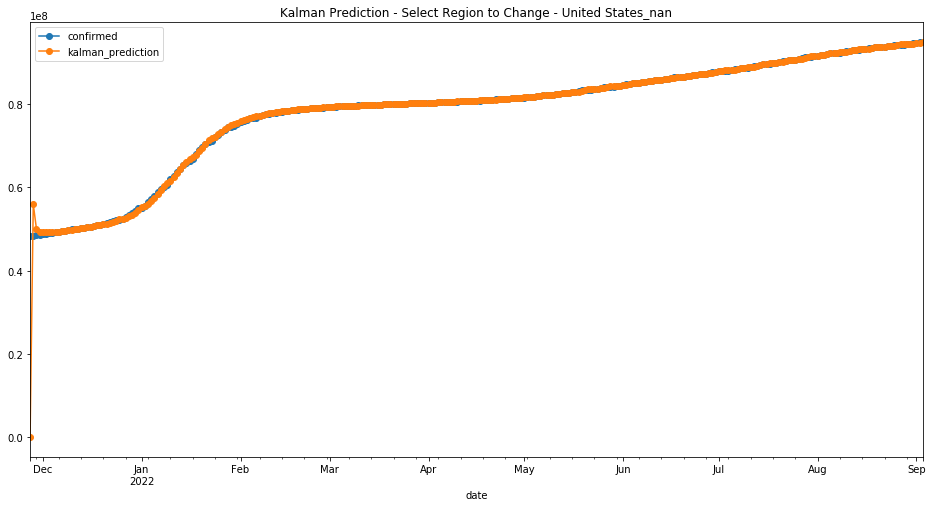

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
219  Russia_nan  1.350298e+12  1.162023e+06  87386.046429


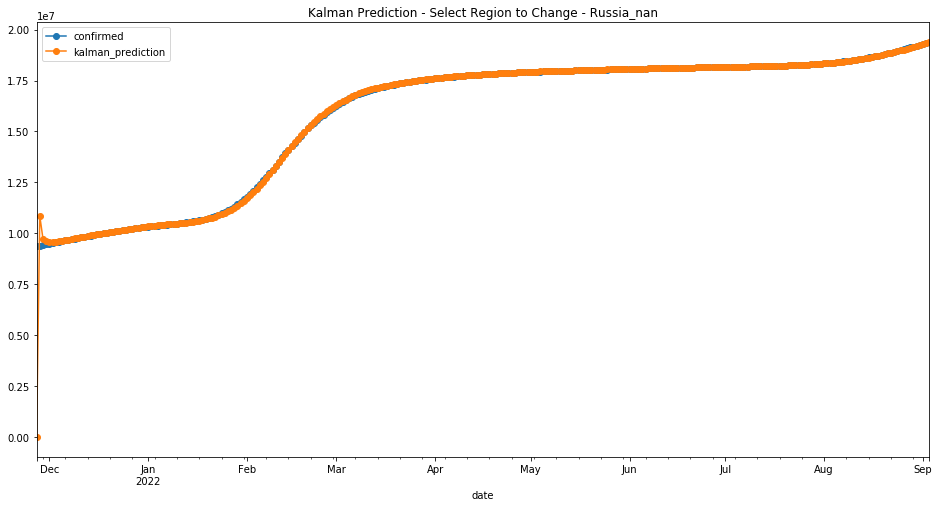

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  4.290958e+12  2.071463e+06  167498.989286


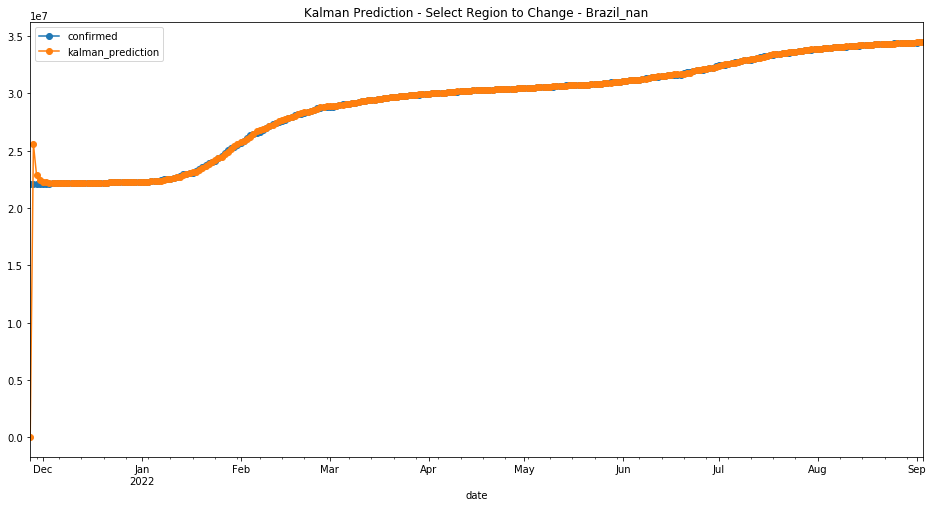

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
273  United Kingdom_nan  1.991331e+12  1.411145e+06  127238.685714


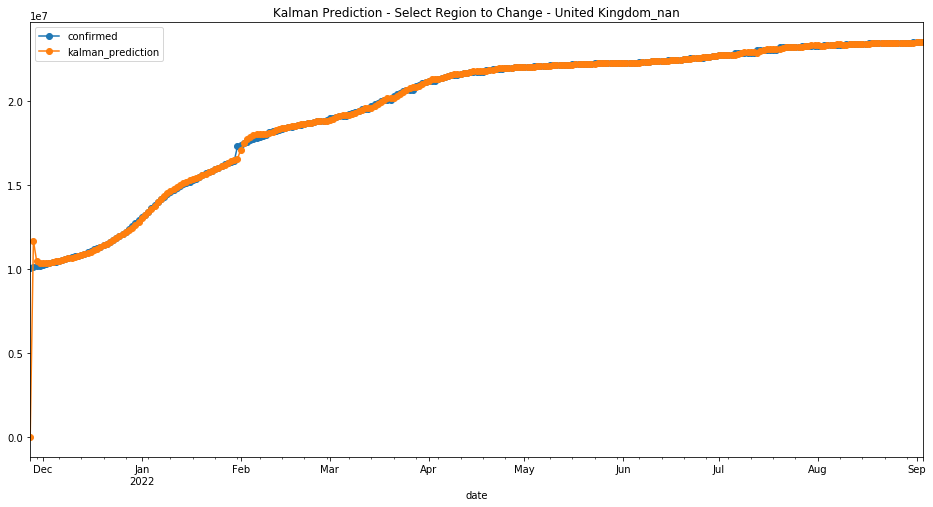

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0jdydfdr
  JVM stdout: /tmp/tmp0jdydfdr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0jdydfdr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 10 months and 8 days !!!
H2O cluster name:           H2O_from_python_unknownUser_n4yvb1
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-08-28
last_train_date= 2022-09-03
first_bootstrap_date= 2022-08-26
boost_bootstrap_date= 2022-08-31
first_test_date= 2022-08-25
last_test_date= 2022-09-04
first_valid_date= 2022-09-02


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   194137.0     191967 2022-08-26  Afghanistan_nan
1   194342.0     191967 2022-08-27  Afghanistan_nan
2   194368.0     192463 2022-08-28  Afghanistan_nan
3   194582.0     192906 2022-08-29  Afghanistan_nan
4   195001.0     193004 2022-08-30  Afghanistan_nan
5   195287.0     193250 2022-08-31  Afghanistan_nan
6   195505.0     193520 2022-09-01  Afghanistan_nan
7   195759.0     193520 2022-09-02  Afghanistan_nan
8   195878.0          0 2022-09-03  Afghanistan_nan
9   329333.0     327961 2022-08-26      Albania_nan
10  329706.0     328299 2022-08-27      Albania_nan
11  330012.0     328515 2022-08-28      Albania_nan
12  330211.0     328571 2022-08-29      Albania_nan
13  330253.0     329017 2022-08-30      Albania_nan
14  330605.0     329352 2022-08-31      Albania_nan
15  330888.0     329615 2022-09-01      Albania_nan
16  331158.0     329862 2022-09-02      Albania_nan
17  331415.0          0 2022-09-03      Albania_nan
18  272258.0     270145 2022-08-26      Algeria_nan
19  272306.0     270175 2022-08-27      Algeria_nan
20  272335.0     270194 2022-08-28      Algeria_nan
21  272351.0     270235 2022-08-29      Algeria_nan
22  272379.0     270272 2022-08-30      Algeria_nan
23  272407.0     270304 2022-08-31      Algeria_nan
24  272435.0     270359 2022-09-01      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175    38559.0      37059 2022-08-30     Bahamas_nan
176    38614.0      37075 2022-08-31     Bahamas_nan
177    38573.0      37081 2022-09-01     Bahamas_nan
178    38613.0      37081 2022-09-02     Bahamas_nan
179    38636.0          0 2022-09-03     Bahamas_nan
180   669846.0     670717 2022-08-26     Bahrain_nan
181   669969.0     670854 2022-08-27     Bahrain_nan
182   670082.0     671055 2022-08-28     Bahrain_nan
183   670259.0     671252 2022-08-29     Bahrain_nan
184   670432.0     671484 2022-08-30     Bahrain_nan
185   670655.0     671697 2022-08-31     Bahrain_nan
186   670866.0     671920 2022-09-01     Bahrain_nan
187   671095.0     672074 2022-09-02     Bahrain_nan
188   671252.0          0 2022-09-03     Bahrain_nan
189  2012719.0    2010944 2022-08-26  Bangladesh_nan
190  2012900.0    2011100 2022-08-27  Bangladesh_nan
191  2013064.0    2011317 2022-08-28  Bangladesh_nan
192  2013309.0    2011560 2022-08-29  Bangladesh_nan
193  2013556.0    2011732 2022-08-30  Bangladesh_nan
194  2013717.0    2011946 2022-08-31  Bangladesh_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220  4483727.0    4482315 2022-08-30  Belgium_nan
221  4481979.0    4482315 2022-08-31  Belgium_nan
222  4482299.0    4488054 2022-09-01  Belgium_nan
223  4489558.0    4488054 2022-09-02  Belgium_nan
224  4487643.0          0 2022-09-03  Belgium_nan
225    69168.0      68187 2022-08-26   Belize_nan
226    69114.0      68187 2022-08-27   Belize_nan
227    69244.0      68187 2022-08-28   Belize_nan
228    69250.0      68238 2022-08-29   Belize_nan
229    69198.0      68238 2022-08-30   Belize_nan
230    69286.0      68302 2022-08-31   Belize_nan
231    69238.0      68302 2022-09-01   Belize_nan
232    69347.0      68350 2022-09-02   Belize_nan
233    69315.0          0 2022-09-03   Belize_nan
234    29484.0      27316 2022-08-26    Benin_nan
235    29484.0      27316 2022-08-27    Benin_nan
236    29484.0      27316 2022-08-28    Benin_nan
237    29484.0      27490 2022-08-29    Benin_nan
238    28815.0      27490 2022-08-30    Benin_nan
239    29722.0      27490 2022-08-31    Benin_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  233397447150.08
# MSE on the validation data =  229901342790584.44
# R^2 on the training data =  0.99900608432604
# R^2 on the validation data =  -0.15912734206464885


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1662267205274_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 233397447150.08
RMSE: 483112.25108672207
MAE: 34562.58482900264
RMSLE: 0.47751785565505084
Mean Residual Deviance: 233397447150.08

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 229901342790584.44
RMSE: 15162497.907356309
MAE: 6131476.42956118
RMSLE: 10.718049112878106
Mean Residual Deviance: 229901342790584.44
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae       training_deviance    validation_rmse     validation_mae     validation_deviance
---  -------------------  ----------  -----------------  ------------------  -----------------  -------------------  ------------------  -----------------  ---------------------
     2022-09-04 04:53:34  0.058 sec   0.0                nan                 nan                nan                  nan                 nan                nan
     2022-09-04 04:53:34  0.470 sec   1.0                599050.387798436    83504.33985008228  358861367121.4566    15350126.243723879  6156517.314189189  235626375698260.53
     2022-09-04 04:53:34  0.621 sec   2.0                541141.8452993303   77871.82873069946  292834496733.9643    13010717.459397657  5747102.894636825  169278768808275.03
     2022-09-04 04:53:35  0.752 sec   3.0                600282.7265845586   69953.70700515926  360339351835.792     13736127.964282889  5887782.569591076  188681211451154.38
     2022-09-04 04:53:35  0.967 sec   4.0                748972.8508558861   69466.83214205045  560960331319.1934    14102981.556261934  5957618.838510874  198894088776264.28
---  ---                  ---         ---                ---                 ---                ---                  ---                 ---                ---
     2022-09-04 04:53:50  16.080 sec  263.0              484264.93758529535  37005.52587943042  234512529774.49002   15131922.173365962  6125294.232986738  228975068660804.44
     2022-09-04 04:53:54  20.120 sec  347.0              490831.1580538629   35716.33640436711  240915225716.49615   15141626.680960454  6127163.932224607  229268858545573.47
     2022-09-04 04:53:58  24.124 sec  419.0              474084.9943062146   34880.30292300906  224756581826.32355   15156880.418289352  6129884.821919533  229731024014323.22
     2022-09-04 04:54:02  28.157 sec  499.0              483230.4003810302   34582.86307095206  233511619852.4108    15162072.663375935  6131393.461845716  229888447449491.8
     2022-09-04 04:54:02  28.473 sec  500.0              483112.25108672207  34562.58482900264  233397447150.08      15162497.907356309  6131476.42956118   229901342790584.44


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  4.17679e+20            1                    0.395143
last_day           3.06251e+20            0.733223             0.289728
region             2.17321e+20            0.520306             0.205595
7_day_change       4.89917e+19            0.117295             0.0463484
3_day_change       2.34907e+19            0.0562412            0.0222233
infected_rate      1.71489e+19            0.0410576            0.0162236
1_day_change       9.83498e+18            0.0235468            0.00930434
7_day_change_rate  9.37263e+18            0.0224398            0.00886694
3_day_change_rate  5.4859e+18             0.0131343            0.00518992
1_day_change_rate  1.45544e+18            0.0034846            0.00137691

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         4.176785e+20           1.000000    0.395143
1           last_day         3.062515e+20           0.733223    0.289728
2             region         2.173207e+20           0.520306    0.205595
3       7_day_change         4.899170e+19           0.117295    0.046348
4       3_day_change         2.349073e+19           0.056241    0.022223
5      infected_rate         1.714888e+19           0.041058    0.016224
6       1_day_change         9.834975e+18           0.023547    0.009304
7  7_day_change_rate         9.372629e+18           0.022440    0.008867
8  3_day_change_rate         5.485901e+18           0.013134    0.005190
9  1_day_change_rate         1.455441e+18           0.003485    0.001377

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


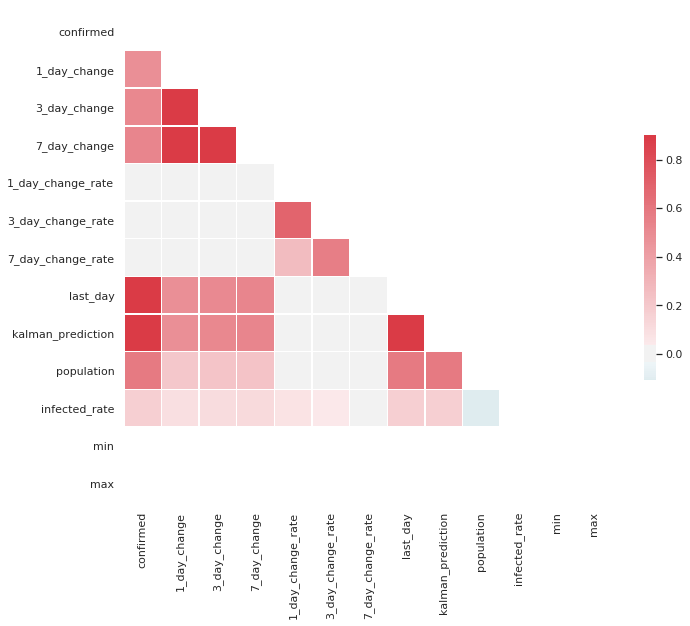

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.481834
3_day_change         0.515029
7_day_change         0.533161
1_day_change_rate    0.017386
3_day_change_rate    0.006870
7_day_change_rate   -0.003564
last_day             0.995706
kalman_prediction    0.996430
population           0.588969
infected_rate        0.170423
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


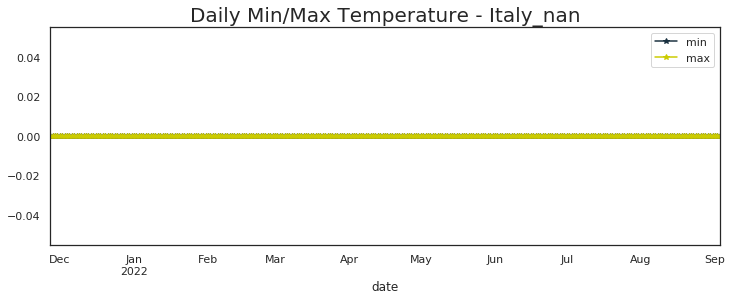

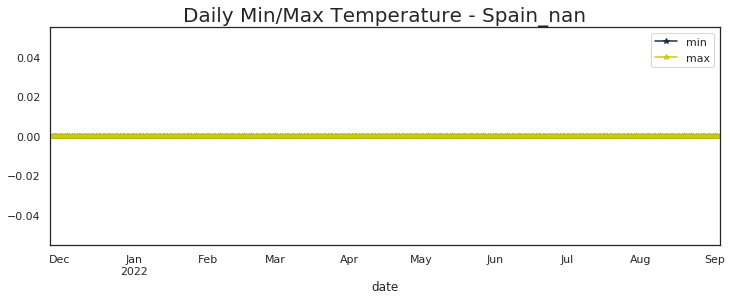

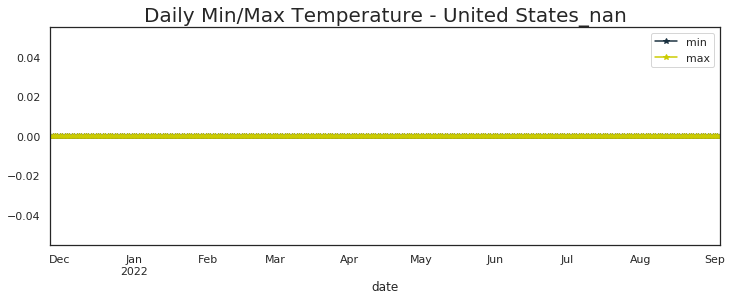

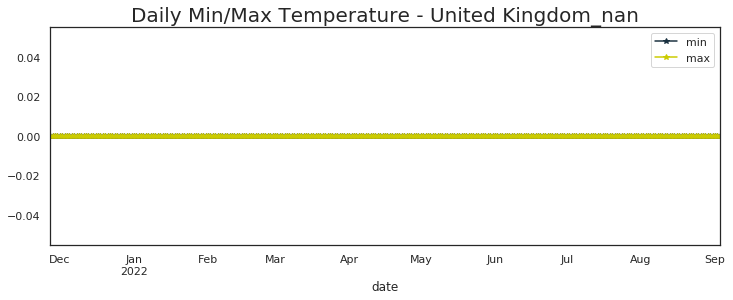

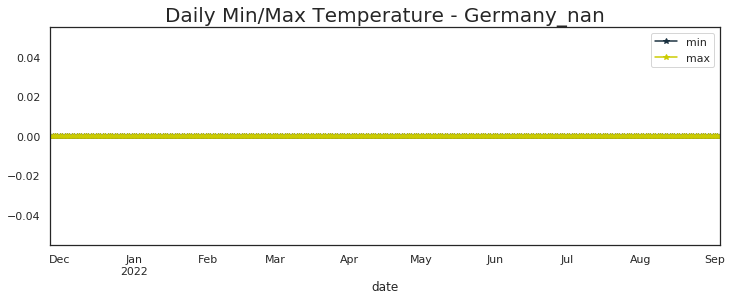

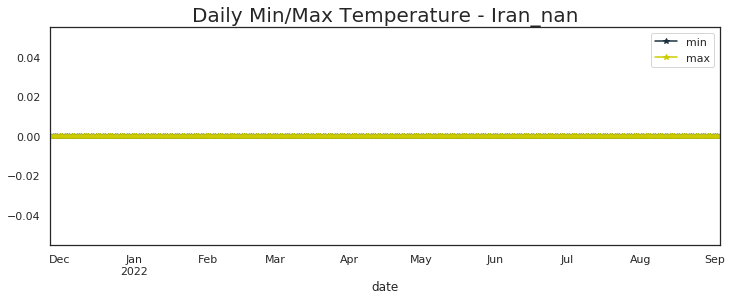

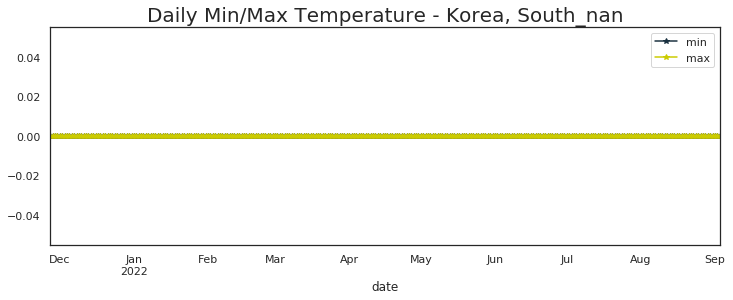

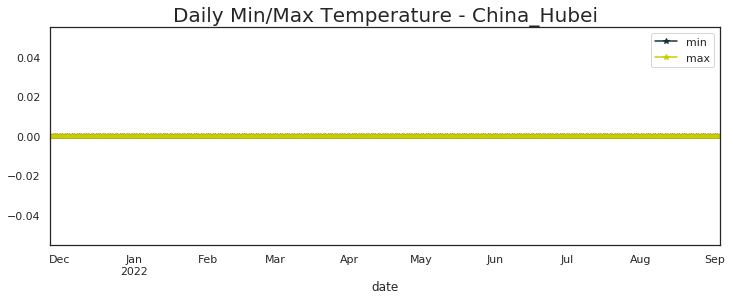

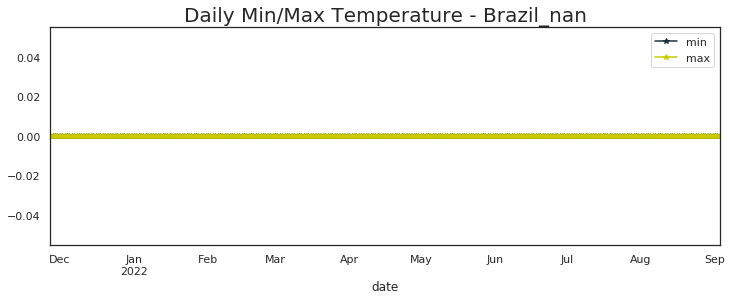

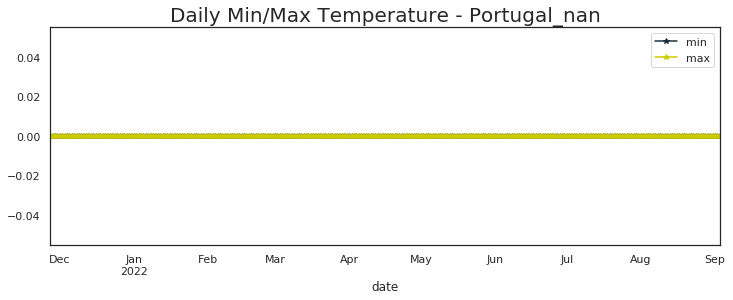

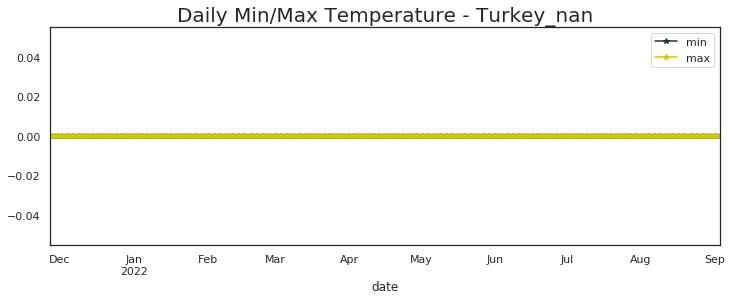

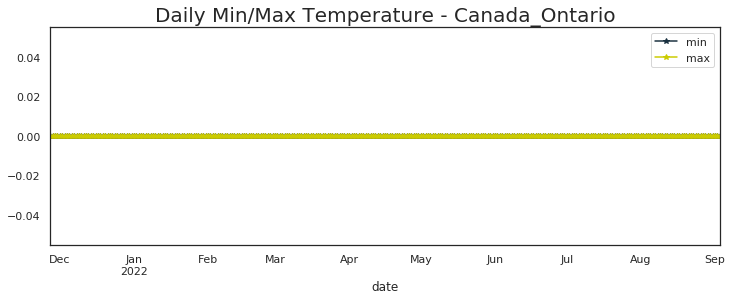

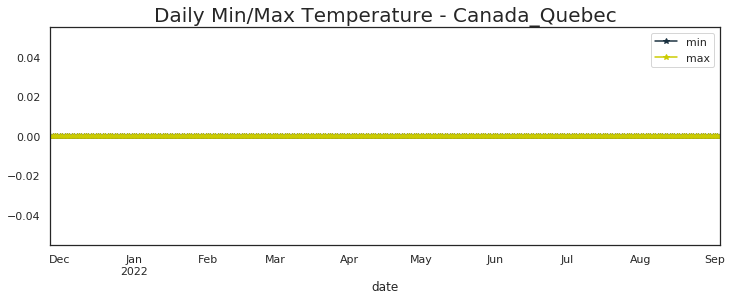

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                           min  max
region                             
United States_nan          0.0  0.0
India_nan                  0.0  0.0
Brazil_nan                 0.0  0.0
France_nan                 0.0  0.0
Germany_nan                0.0  0.0
United Kingdom_nan         0.0  0.0
Korea, South_nan           0.0  0.0
Italy_nan                  0.0  0.0
Russia_nan                 0.0  0.0
Japan_nan                  0.0  0.0
Turkey_nan                 0.0  0.0
Spain_nan                  0.0  0.0
Vietnam_nan                0.0  0.0
Argentina_nan              0.0  0.0
Netherlands_nan            0.0  0.0
Iran_nan                   0.0  0.0
Mexico_nan                 0.0  0.0
Indonesia_nan              0.0  0.0
Colombia_nan               0.0  0.0
Poland_nan                 0.0  0.0
Portugal_nan               0.0  0.0
Taiwan*_nan                0.0  0.0
Ukraine_nan                0.0  0.0
Austria_nan                0.0  0.0
Malaysia_nan               0

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

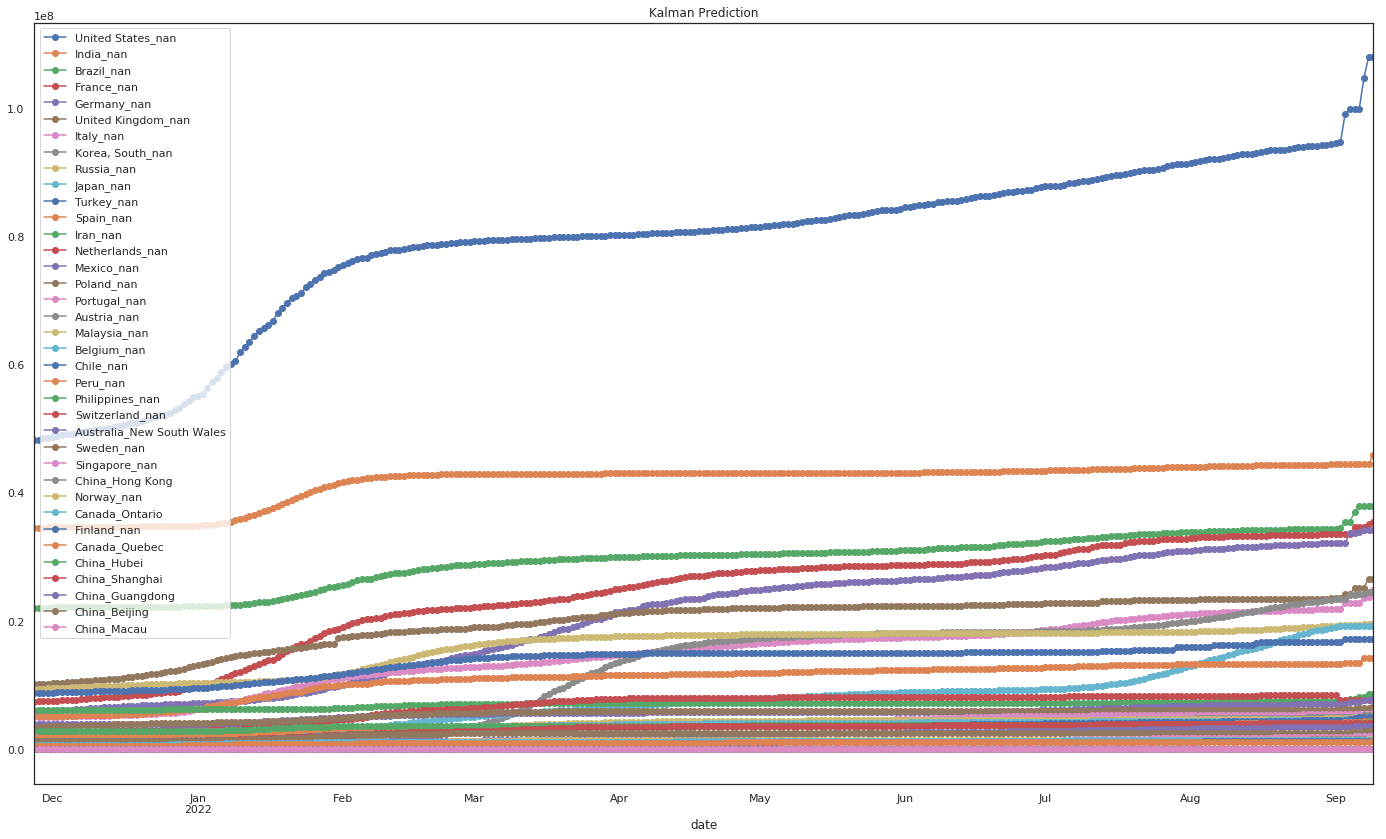

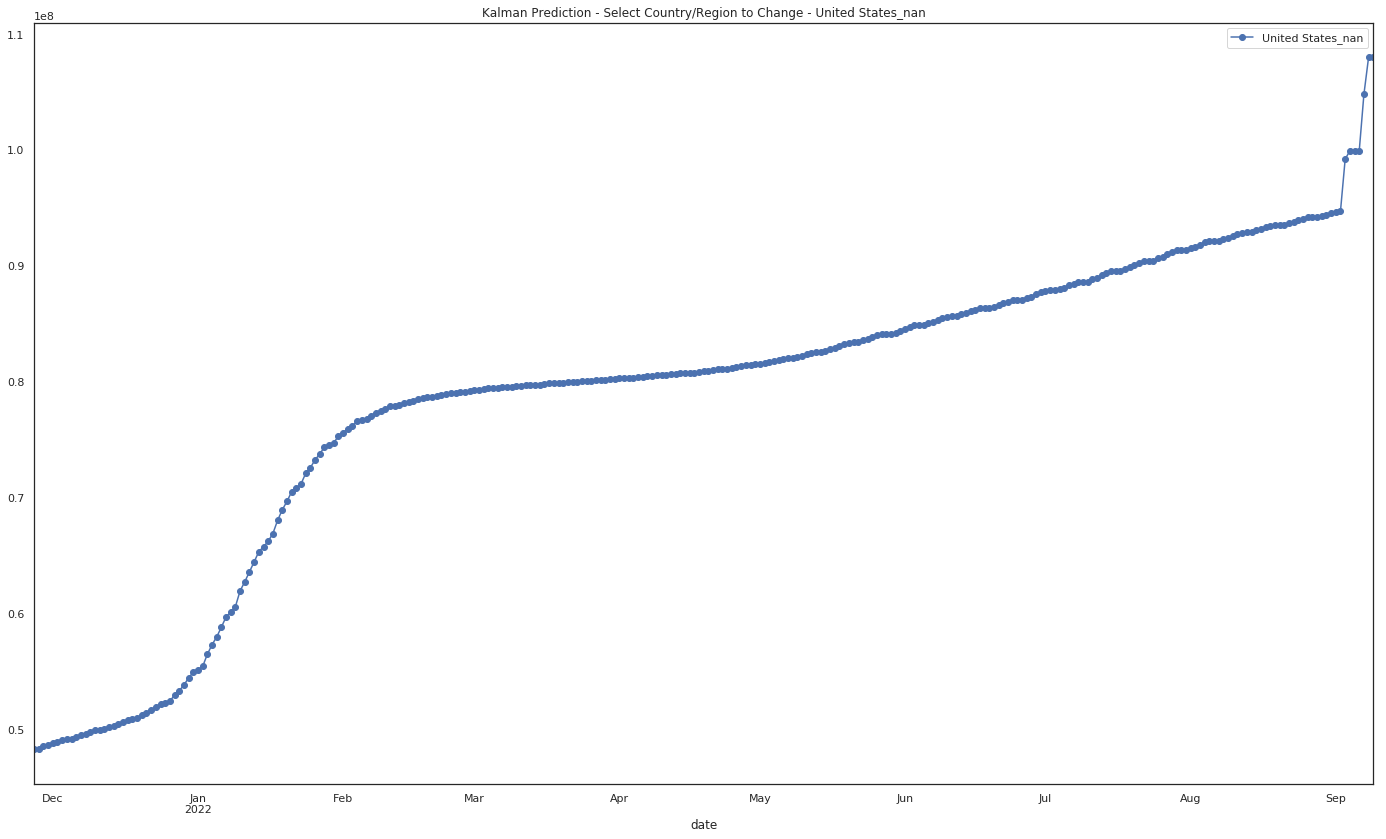

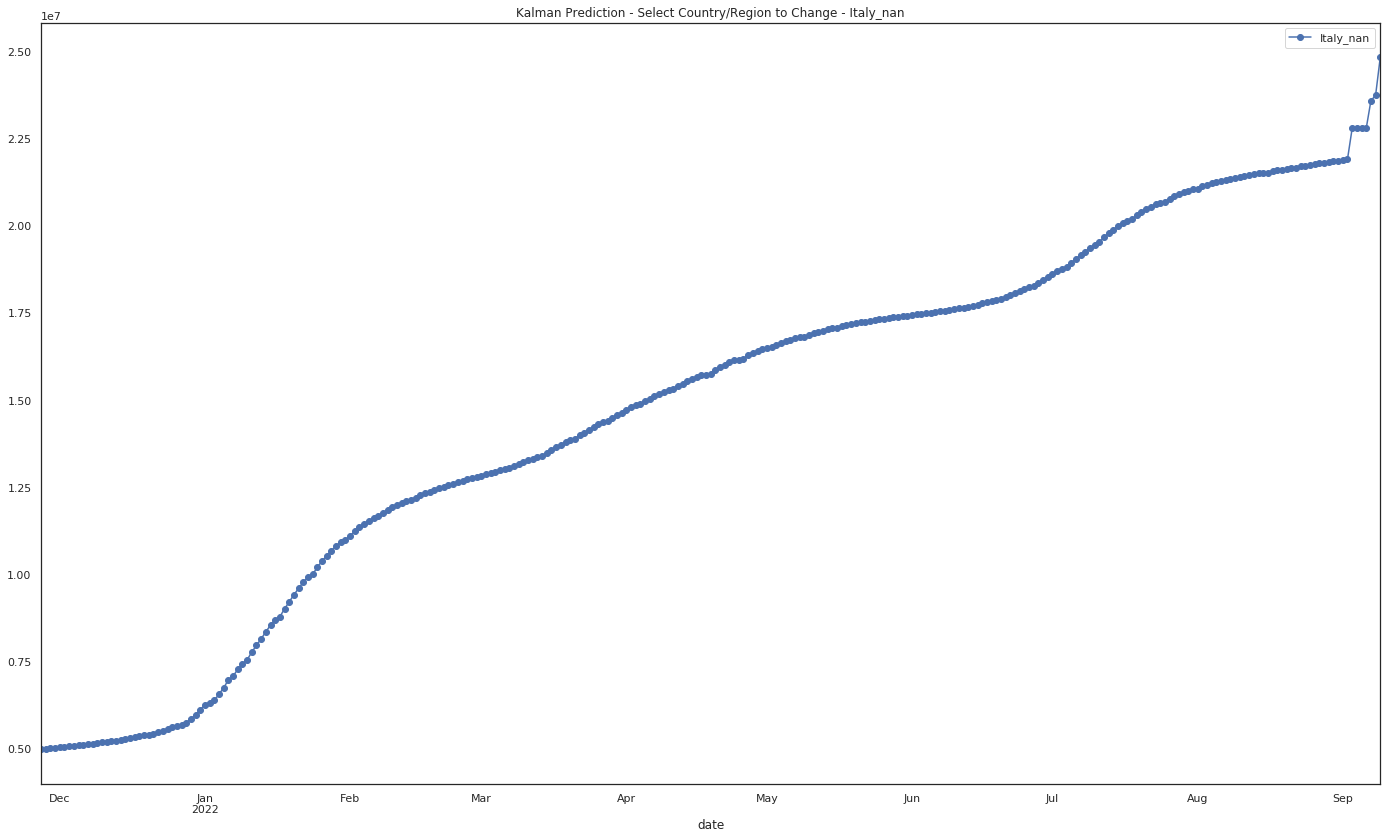

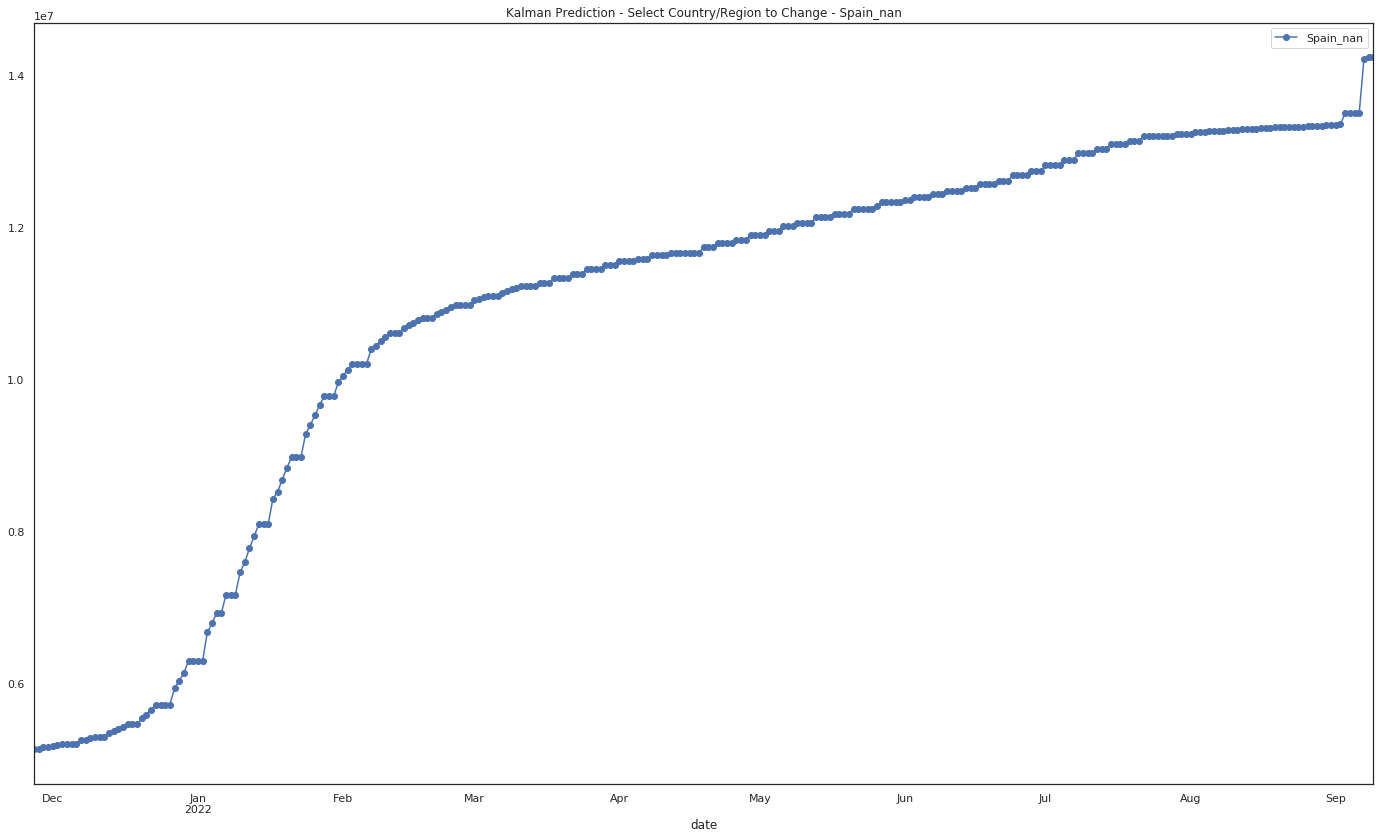

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


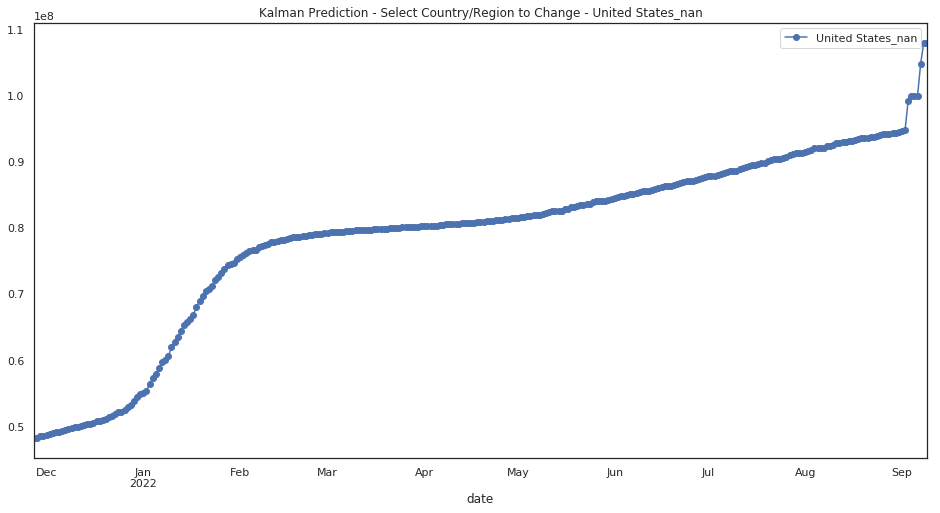

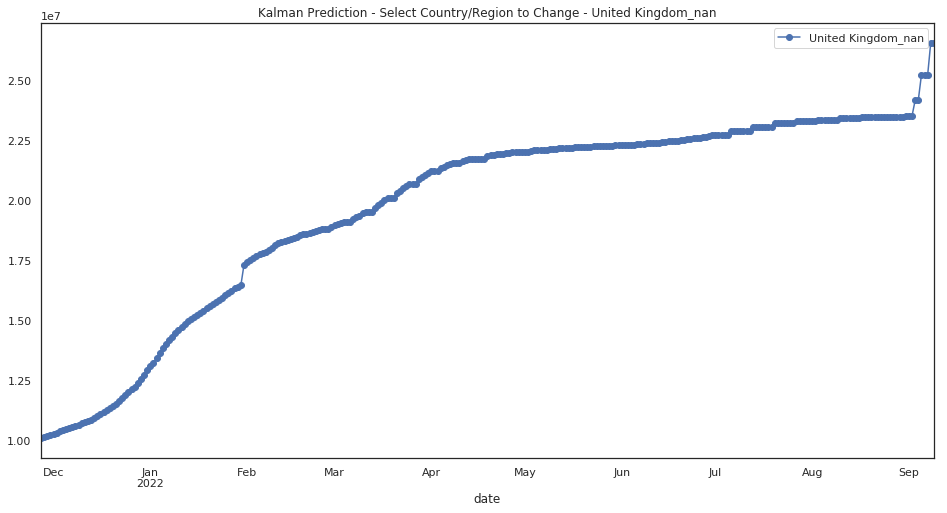

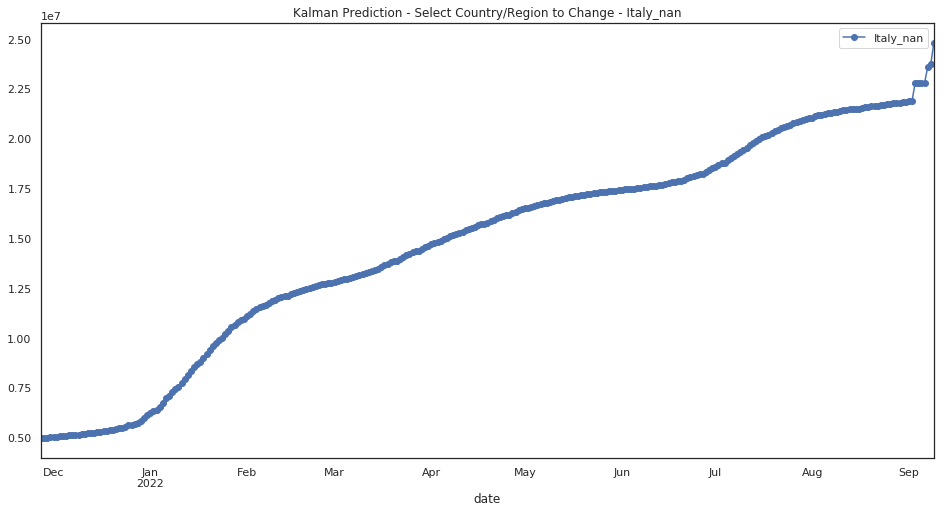

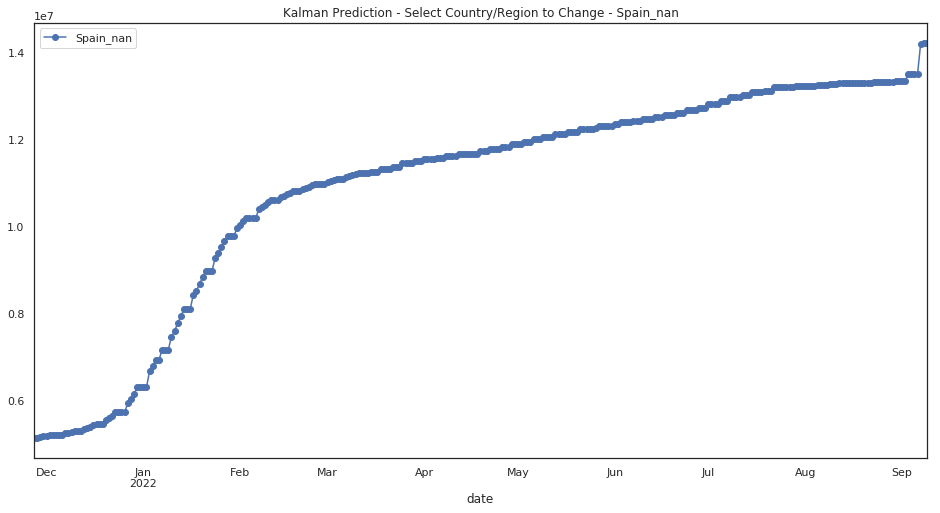

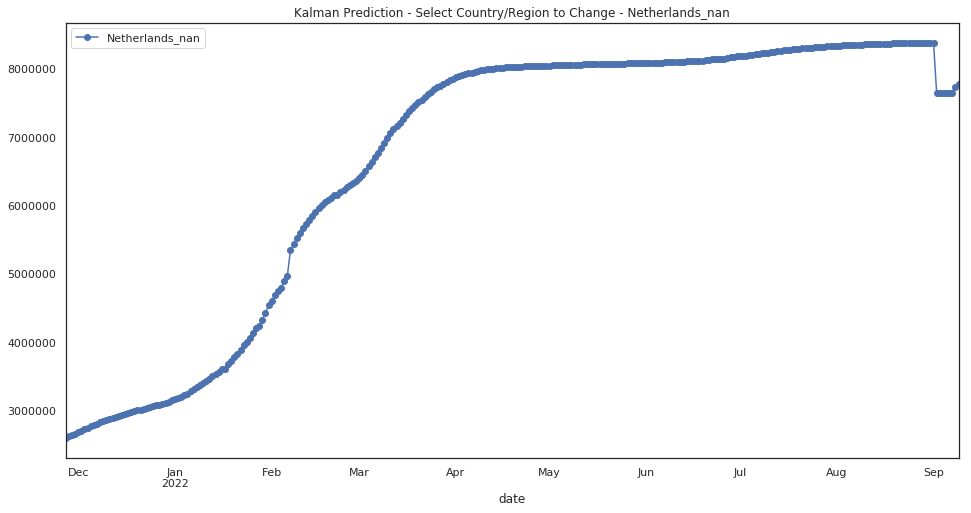

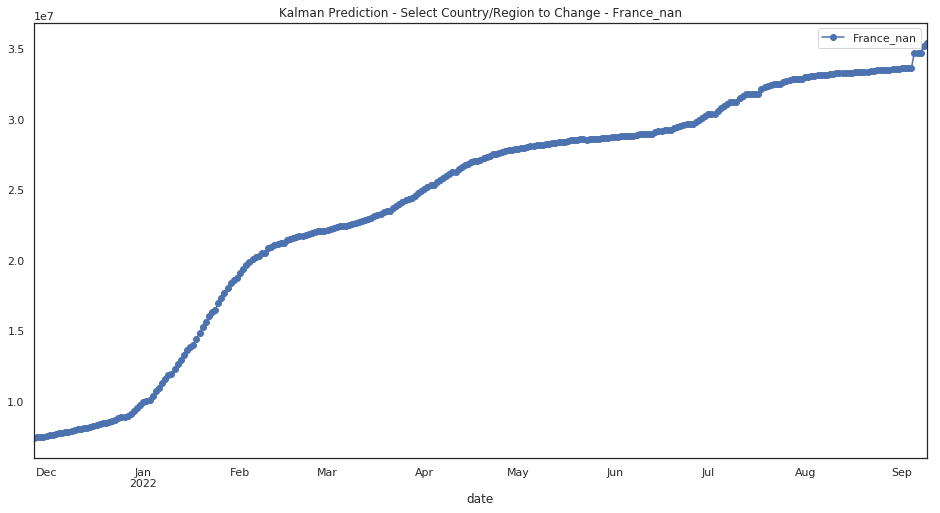

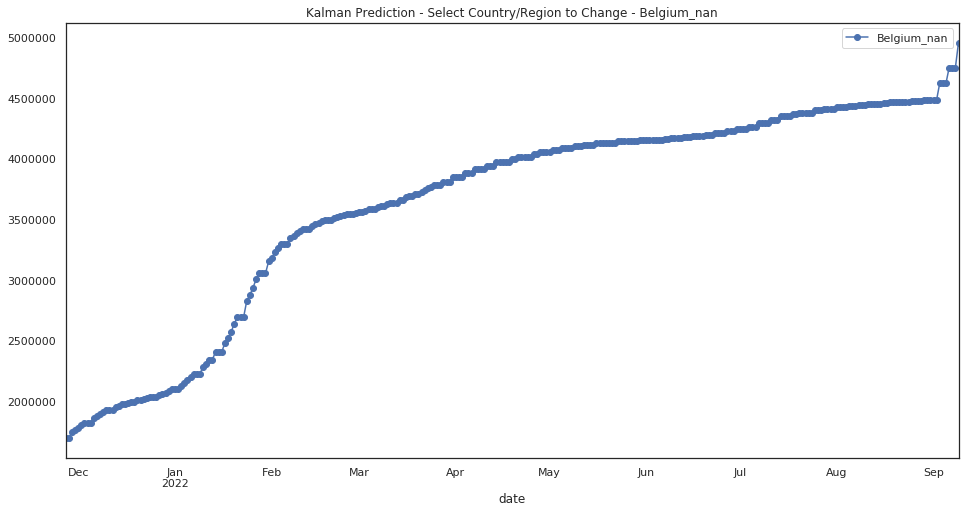

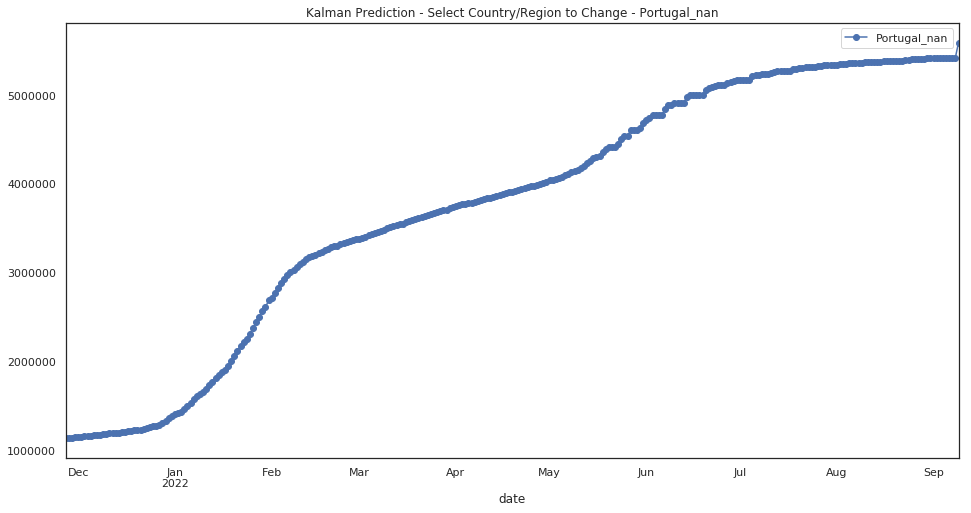

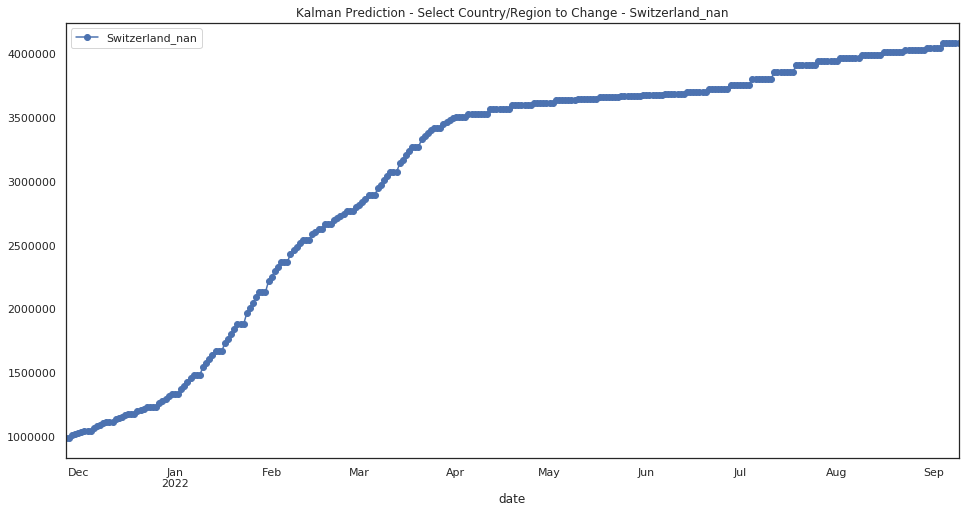

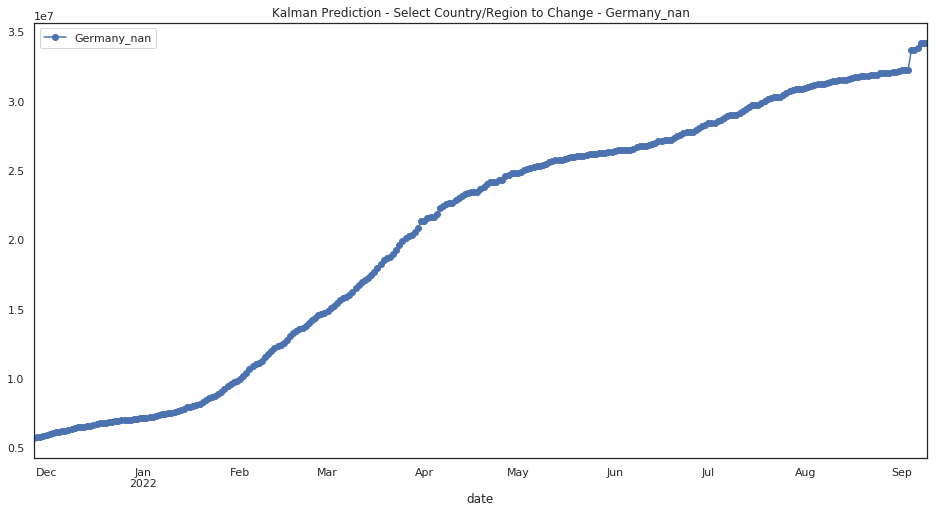

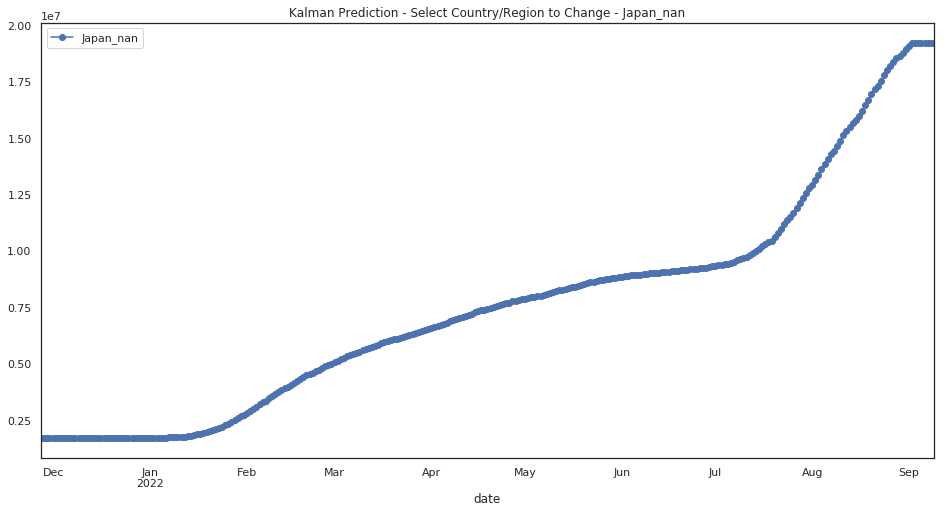

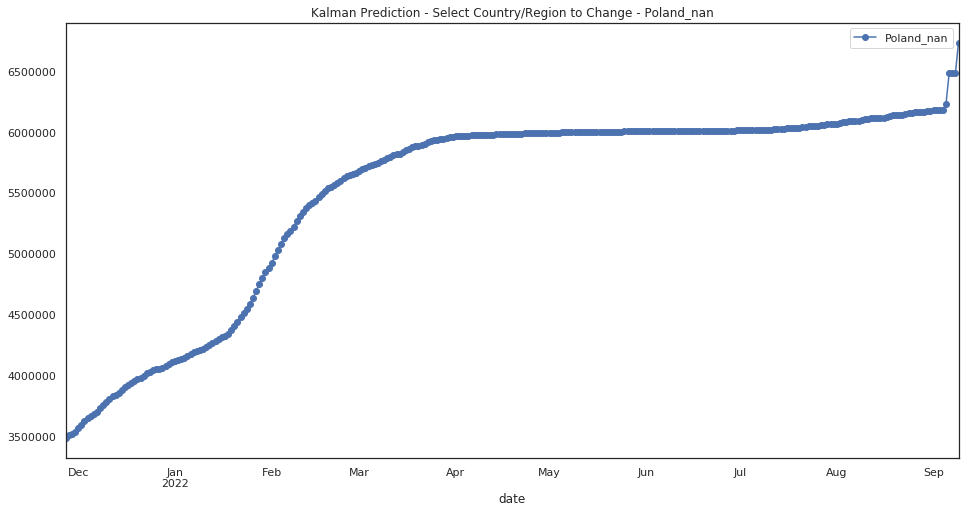

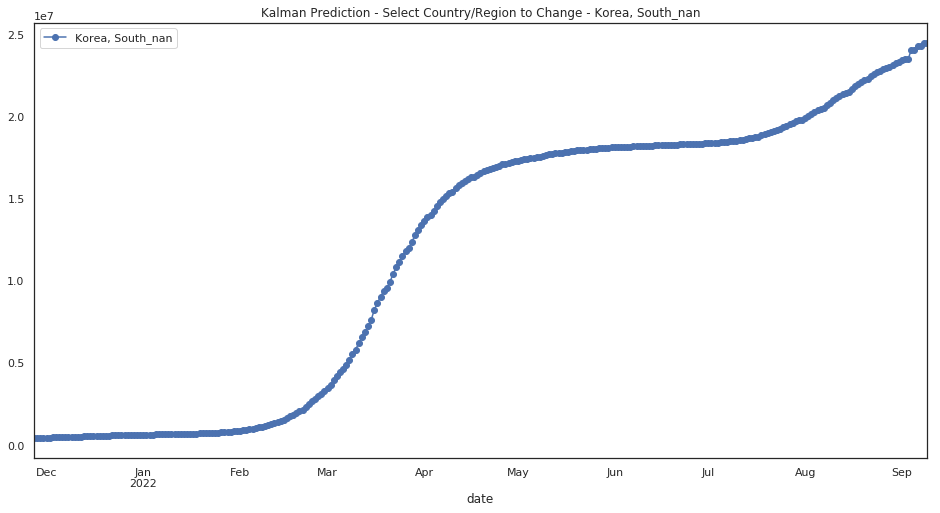

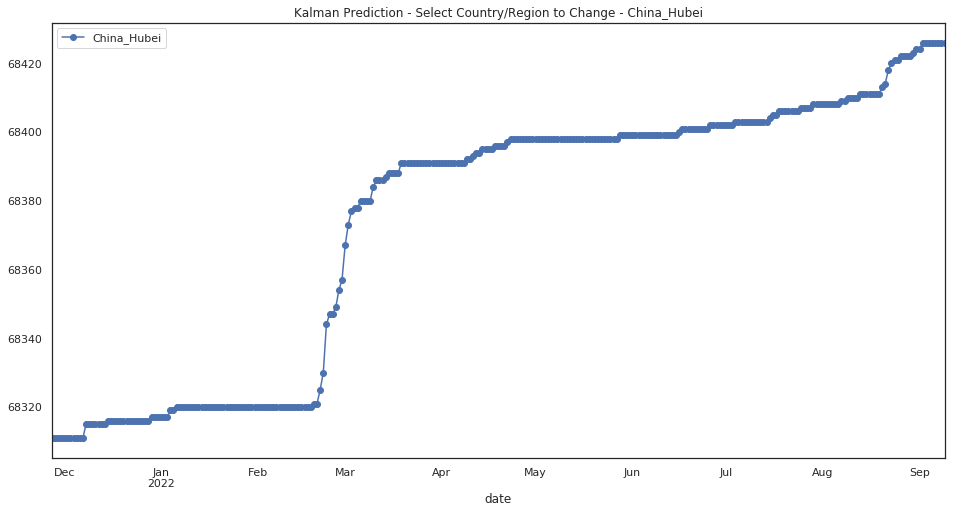

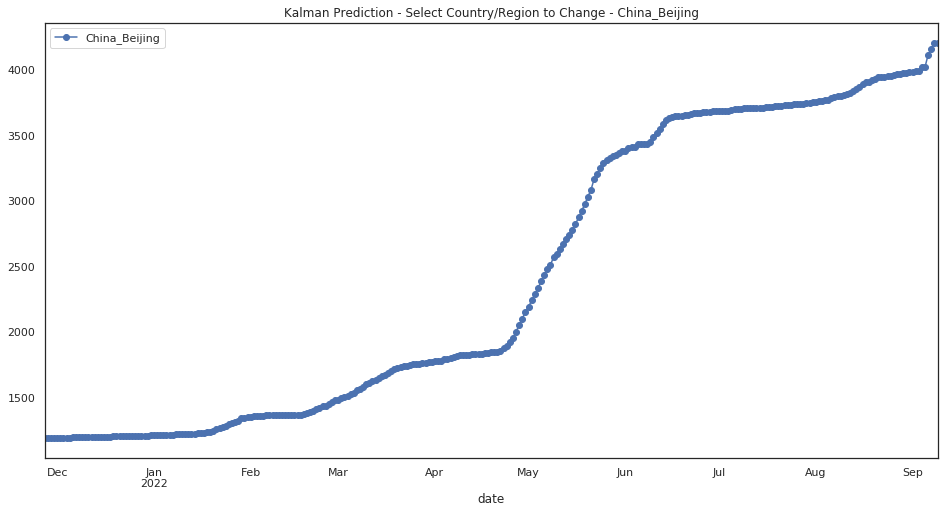

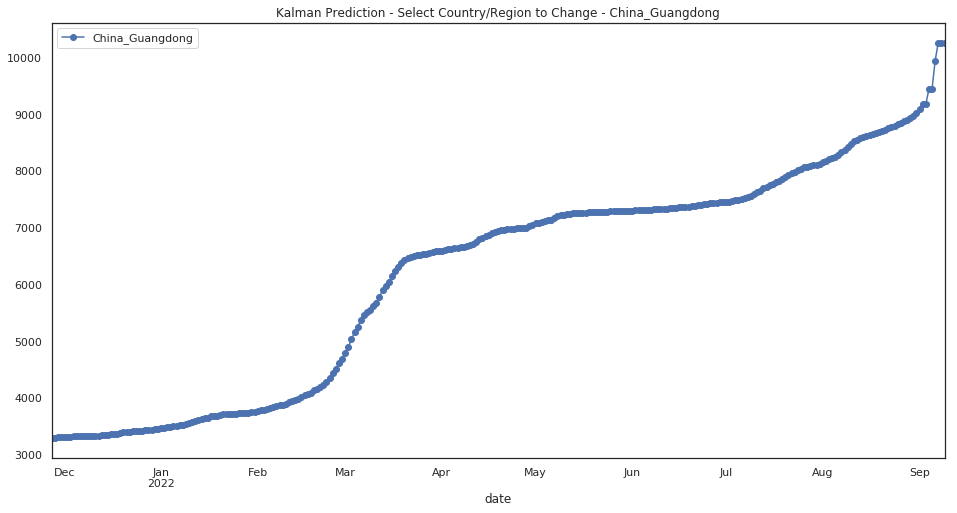

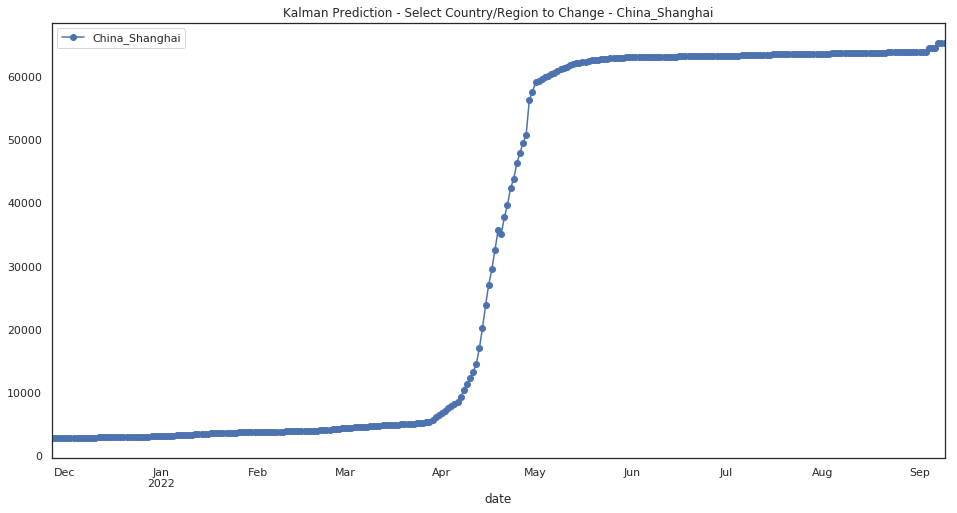

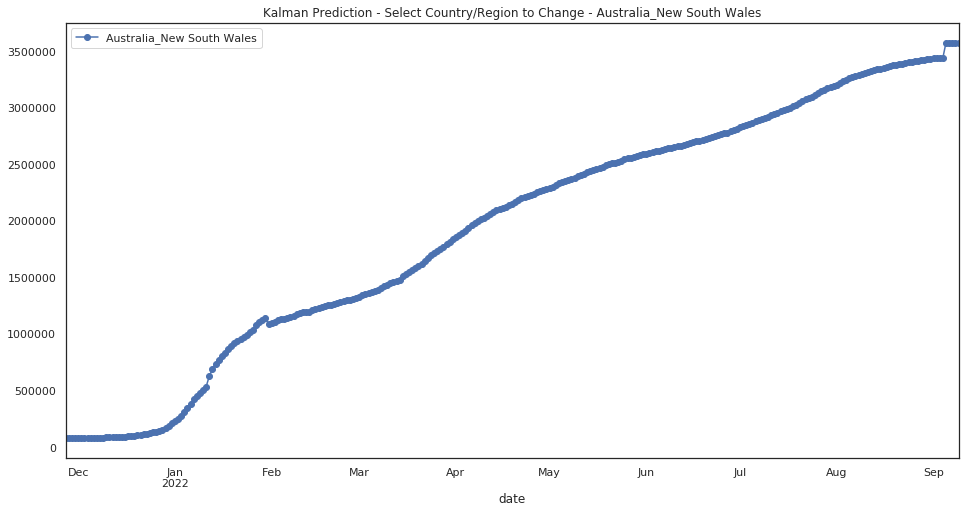

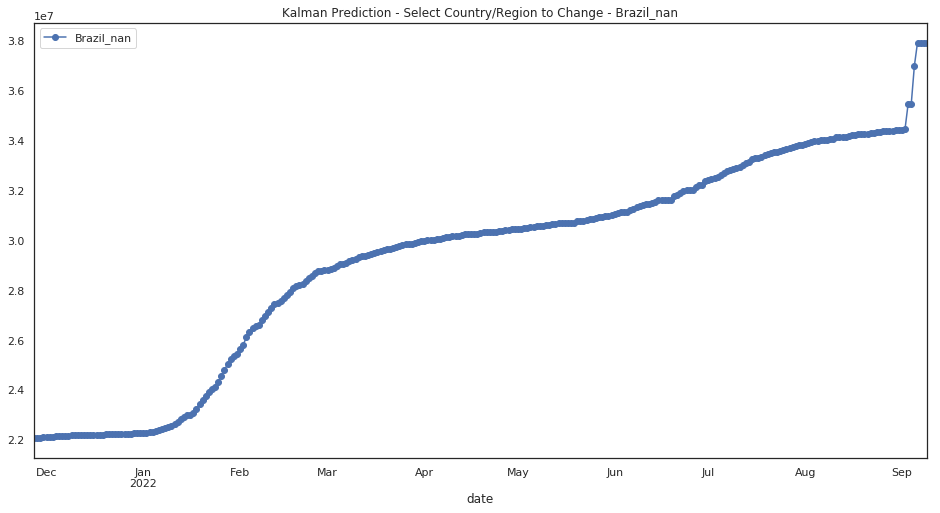

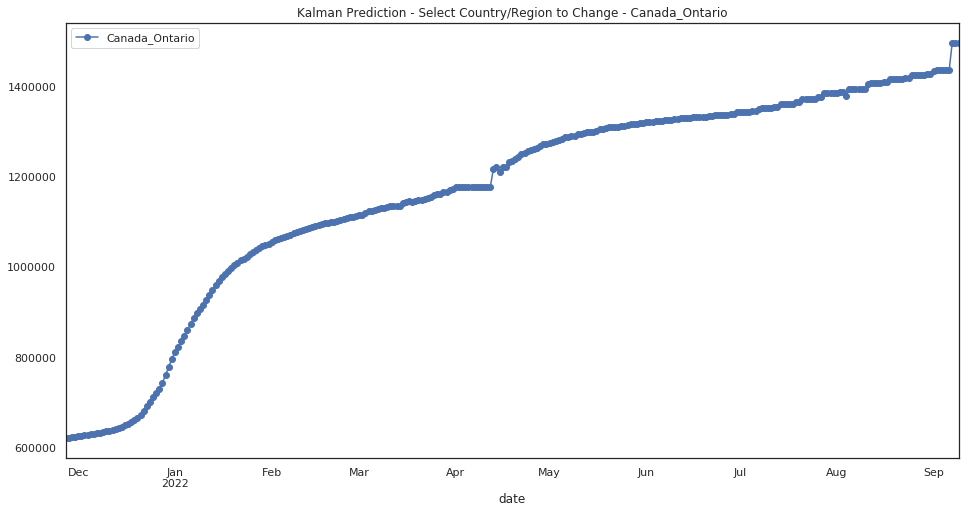

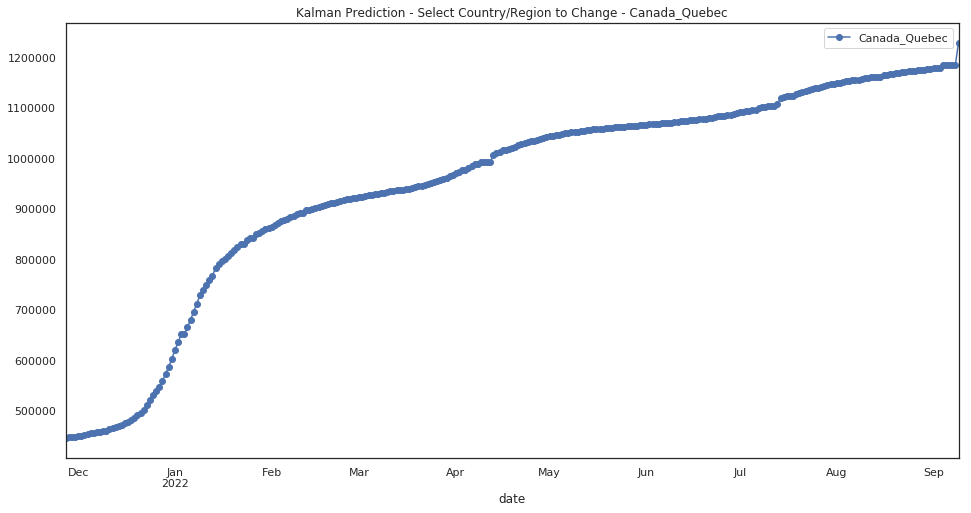

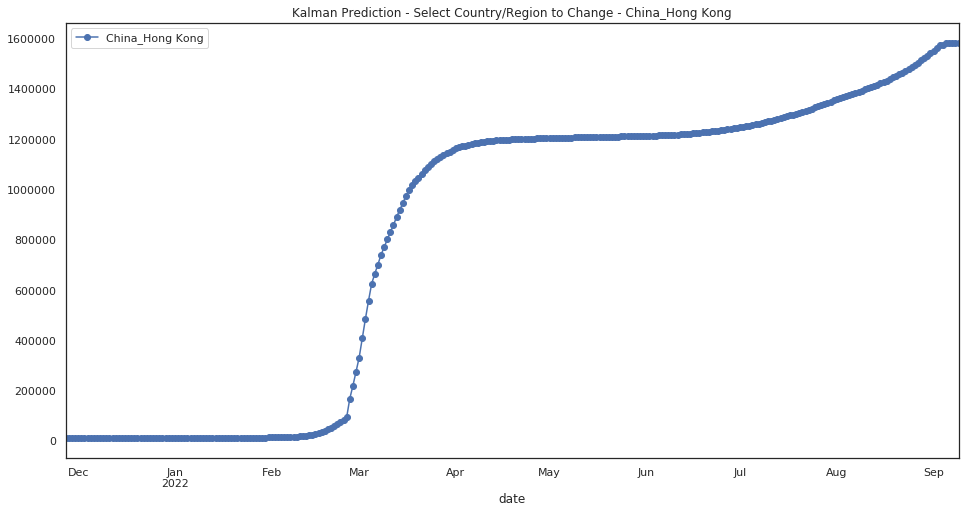

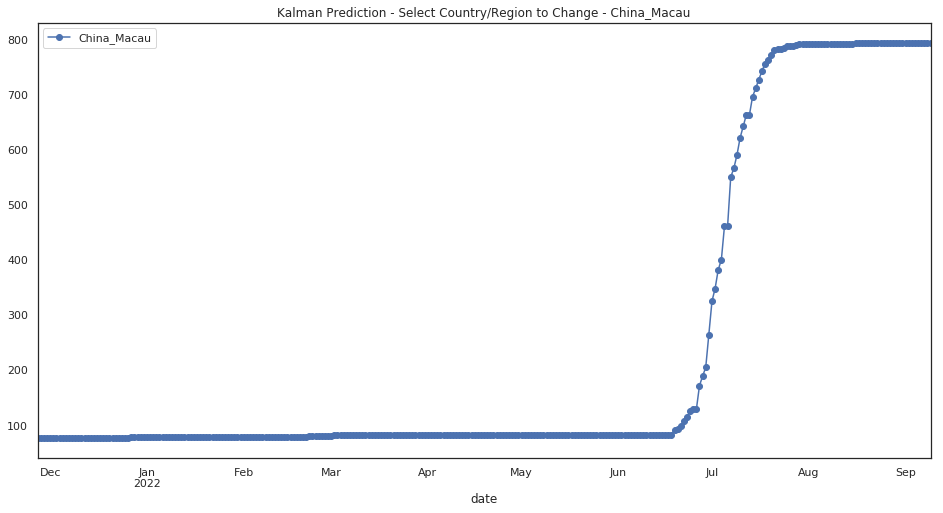

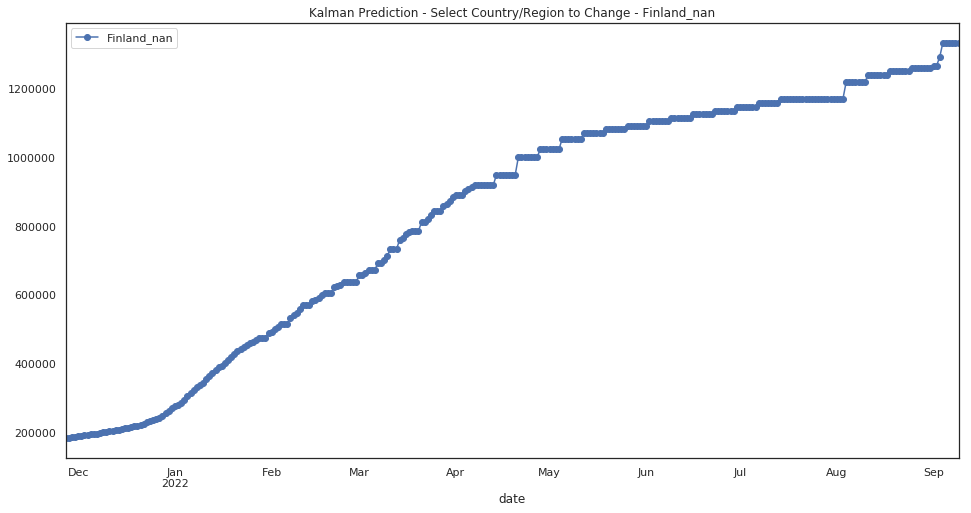

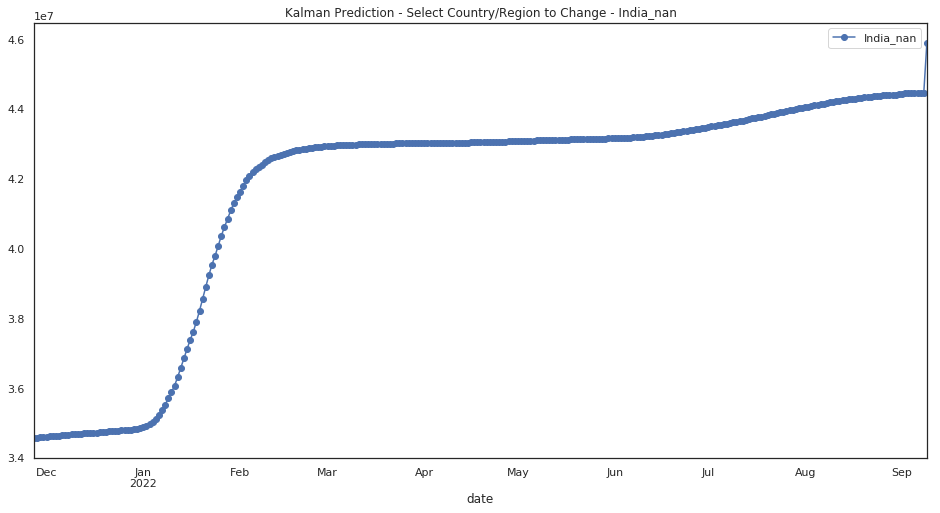

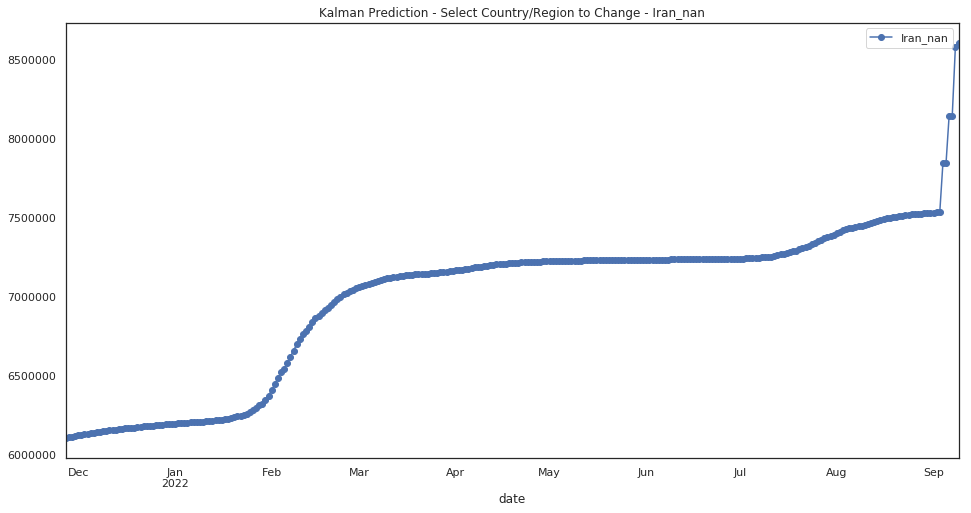

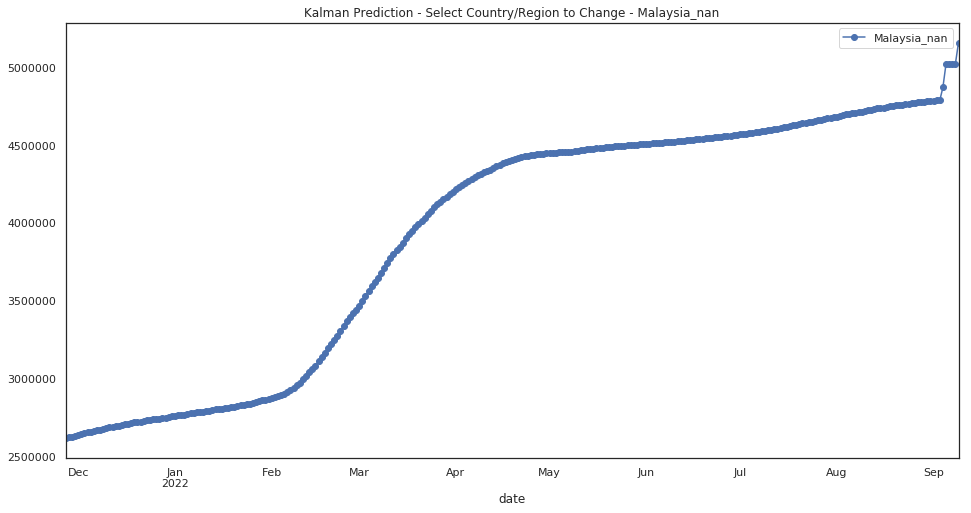

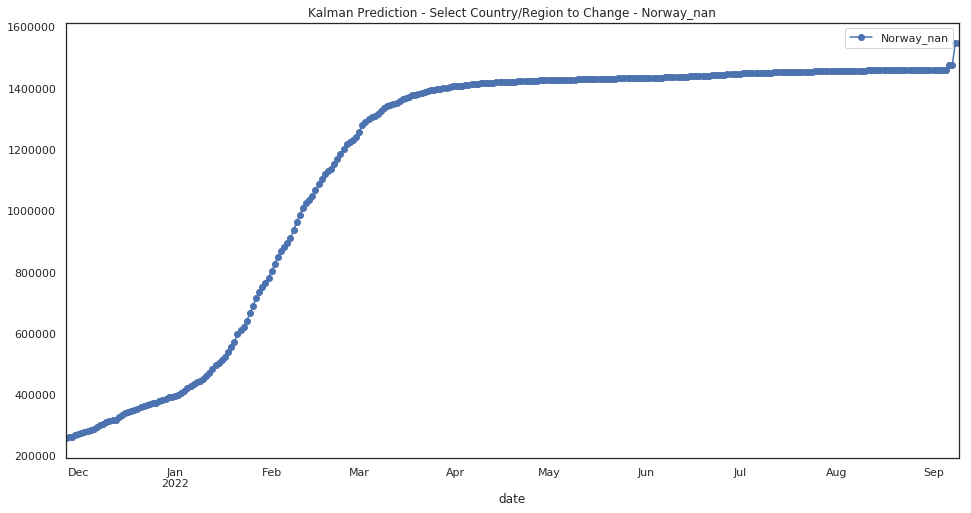

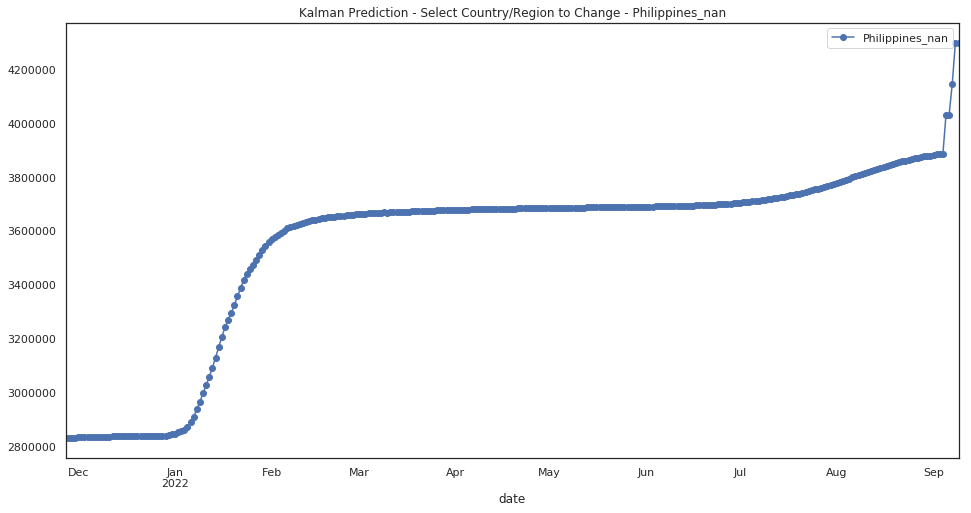

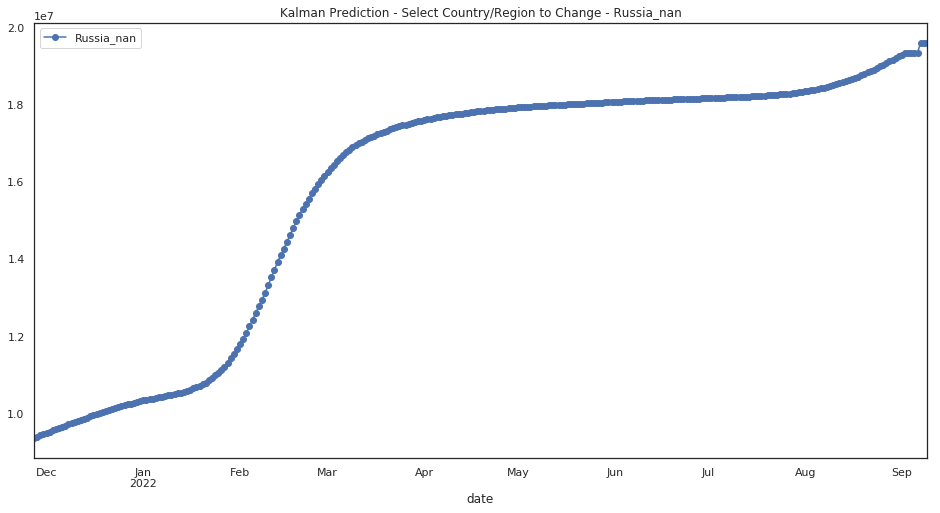

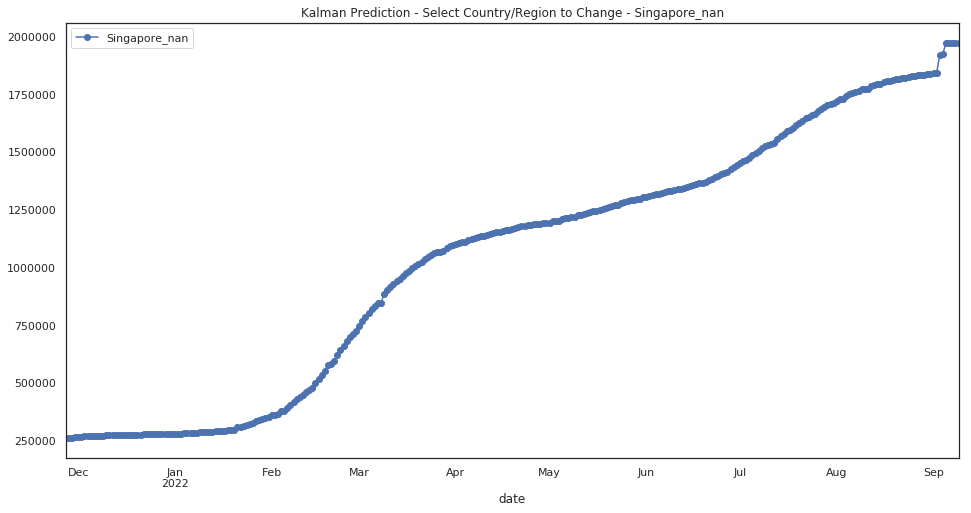

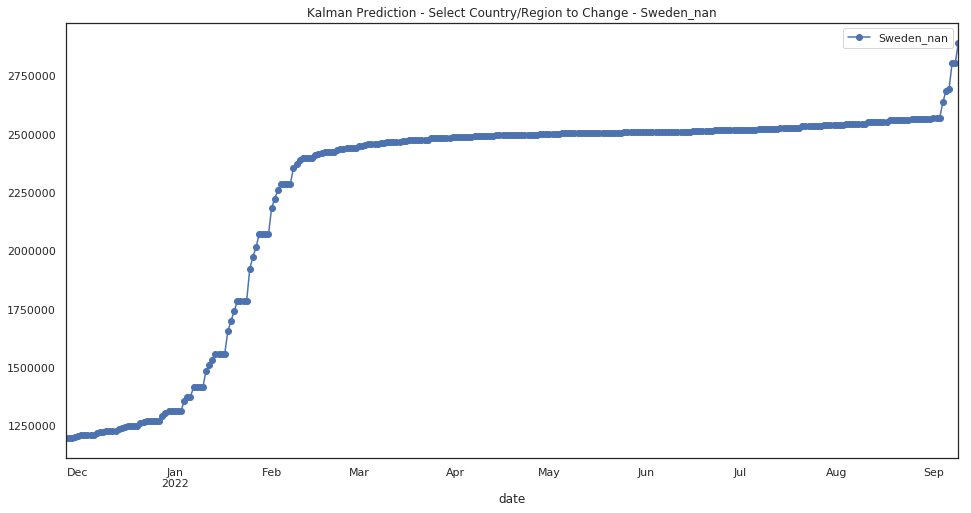

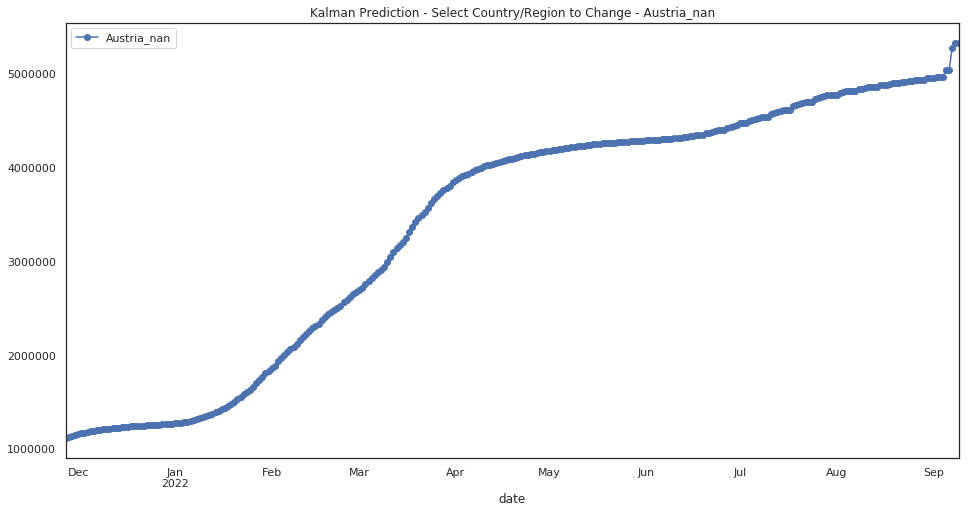

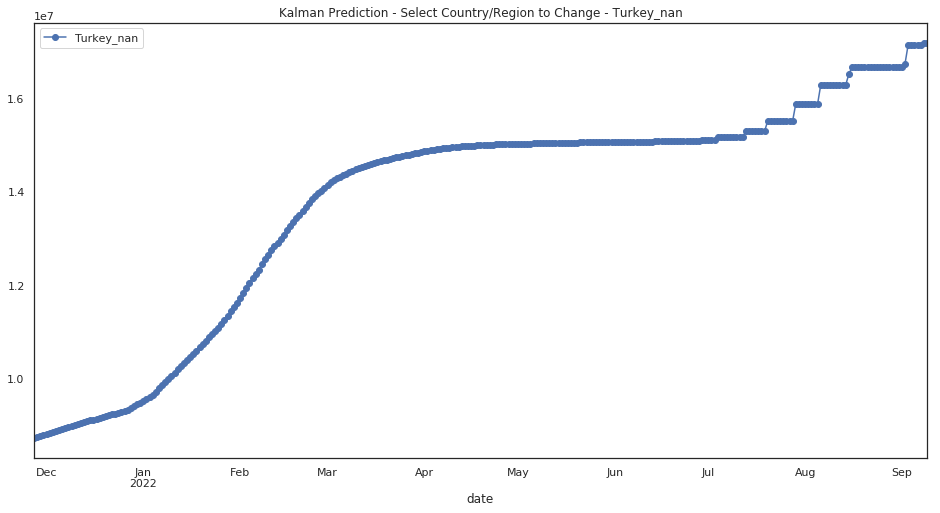

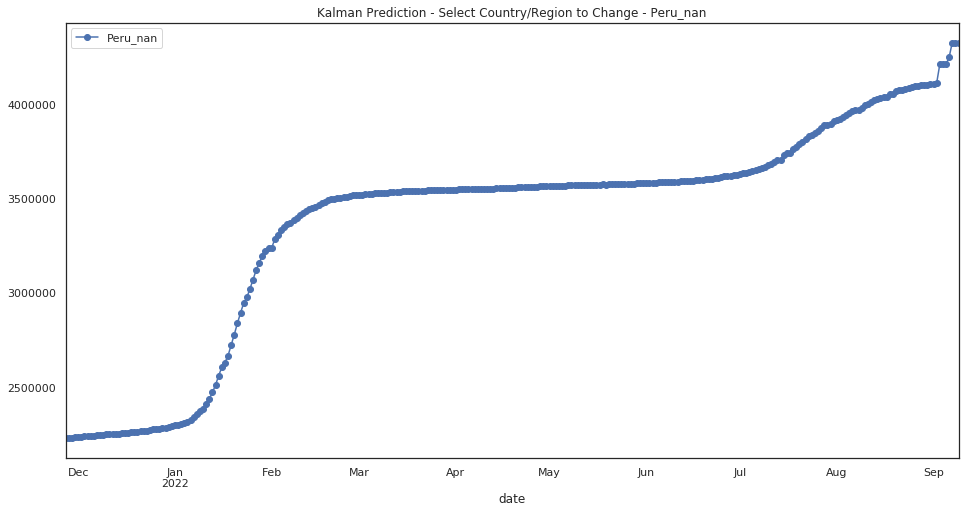

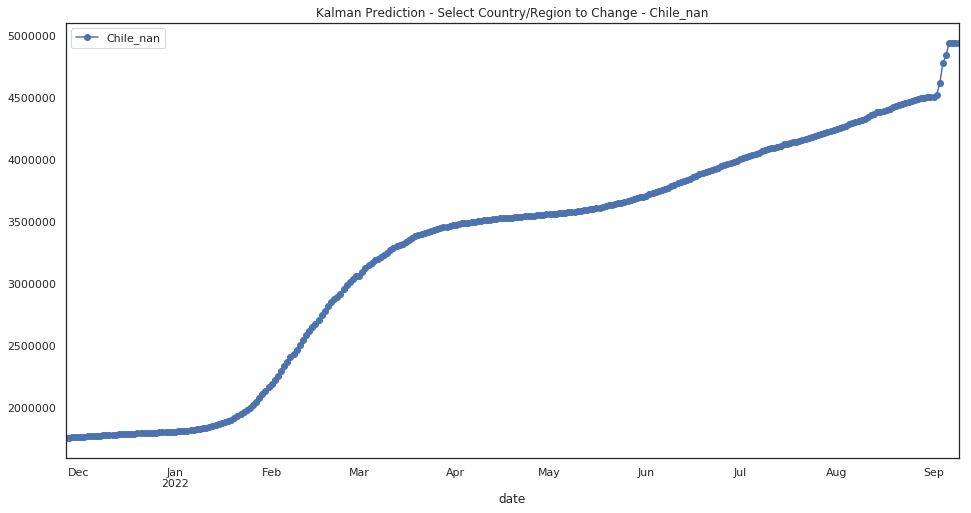

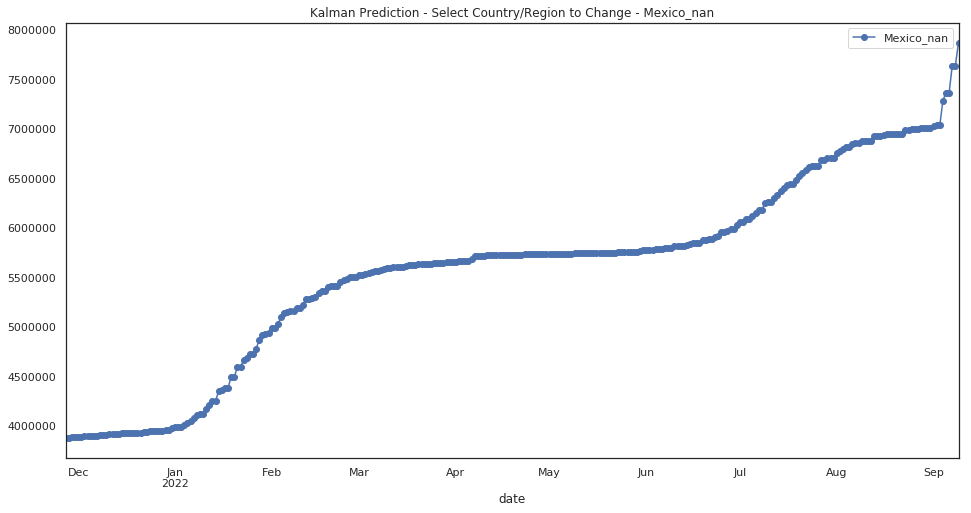

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-09-09 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     107999008.0
India_nan                                           NaN      45906151.0
Brazil_nan                                          NaN      37920316.0
France_nan                                          NaN      35425763.0
Germany_nan                                         NaN      34224798.0
United Kingdom_nan                                  NaN      26575678.0
Italy_nan                                           NaN      24827807.0
Korea, South_nan                                    NaN      24504628.0
Russia_nan                                          NaN      19603342.0
Japan_nan                                           NaN      19229782.0
Turkey_nan                                          NaN      17203803.0
Spain_nan                                           NaN      14235989.0
Vietnam_nan                                         NaN      12185253.0
Argentina_nan                                       NaN       9788358.0
Iran_nan                                            NaN       8604574.0
Netherlands_nan                                     NaN       8386189.0
Mexico_nan                                          NaN       7874037.0
Poland_nan                                          NaN       6737138.0
Colombia_nan                                        NaN       6550333.0
Indonesia_nan                                       NaN       6366518.0
Taiwan*_nan                                         NaN       6109048.0
Portugal_nan                                        NaN       5594631.0
Ukraine_nan                                         NaN       5342118.0
Austria_nan                                         NaN       5333940.0
Malaysia_nan                                        NaN       5158501.0
Greece_nan                                          NaN       5095515.0
Belgium_nan                                         NaN       4957421.0
Chile_nan                                           NaN       4943645.0
Thailand_nan                                        NaN       4756373.0
Israel_nan                                          NaN       4731305.0
...                                                 ...             ...
China_Tianjin                                       NaN          2222.0
China_Hebei                                         NaN          2175.0
United Kingdom_Falkland Islands (Malvinas)          NaN          2051.0
China_Liaoning                                      NaN          1903.0
China_Anhui                                         NaN          1660.0
China_Jiangxi                                       NaN          1584.0
China_Hunan                                         NaN          1569.0
China_Gansu                                         NaN          1460.0
United Kingdom_Montserrat                           NaN          1258.0
China_Xinjiang                                      NaN          1190.0
China_Tibet                                         NaN          1070.0
China_Chongqing                                     NaN          1050.0
Summer Olympics 2020_nan                            NaN           865.0
France_Wallis and Futuna                            NaN           804.0
China_Macau                                         NaN           794.0
Diamond Princess_nan                                NaN           715.0
Winter Olympics 2022_nan                            NaN           569.0
China_Shanxi                                        NaN           496.0
China_Qinghai                                       NaN           263.0
China_Guizhou                                       NaN           212.0
China_Ningxia                                       NaN           134.0
Holy See_nan                                        NaN            29.0
Canada_Repatriated Travellers                       NaN            14.0
Canada_Grand Princess                               NaN            14.0
Antarctica_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-11-27         275481.0     311372.0     320650.0     155281.0   
2021-11-28         275504.0     311730.0     320797.0     155281.0   
2021-11-29         157218.0     199555.0     210152.0      16712.0   
2021-11-30         157260.0     199750.0     210344.0      16712.0   
2021-12-01         157894.0     200249.0     211237.0      17115.0   
2021-12-02         157917.0     200669.0     211435.0      17426.0   
2021-12-03         157955.0     201066.0     211626.0      17658.0   
2021-12-04         157975.0     201445.0     211813.0      18010.0   
2021-12-05         159570.0     203245.0     213498.0      18994.0   
2021-12-06         159610.0     203442.0     213688.0      19385.0   
2021-12-07         159618.0     203812.0     213883.0      18631.0   
2021-12-08         159661.0     204131.0     214072.0      18815.0   
2021-12-09         159697.0     204369.0     214252.0      20231.0   
2021-12-10         159715.0     204730.0     214459.0      19272.0   
2021-12-11         159733.0     205033.0     214673.0      19440.0   
2021-12-12         159755.0     205308.0     214870.0      20288.0   
2021-12-13         159766.0     205473.0     215079.0      20036.0   
2021-12-14         159782.0     205821.0     215304.0      20525.0   
2021-12-15         159789.0     206133.0     215545.0      20136.0   
2021-12-16         159844.0     206446.0     215759.0      21295.0   
2021-12-17         159844.0     206746.0     216046.0      20549.0   
2021-12-18         159872.0     207067.0     216325.0      21153.0   
2021-12-19         159909.0     207305.0     216589.0      21153.0   
2021-12-20         159911.0     207448.0     216835.0      21381.0   
2021-12-21         159940.0     207792.0     217132.0      21062.0   
2021-12-22         159961.0     208117.0     217413.0      21926.0   
2021-12-23         159992.0     208445.0     217705.0      21372.0   
2021-12-24         160004.0     208744.0     218065.0      21571.0   
2021-12-25         160021.0     209060.0     218350.0      21730.0   
2021-12-26         160069.0     209245.0     218620.0      22187.0   
...                     ...          ...          ...          ...   
2022-08-12         190684.0     321936.0     270921.0      45899.0   
2022-08-13         190833.0     322529.0     271064.0      45899.0   
2022-08-14         191048.0     322991.0     271197.0      45899.0   
2022-08-15         191321.0     323314.0     271324.0      45899.0   
2022-08-16         191468.0     323929.0     271436.0      45899.0   
2022-08-17         191722.0     324496.0     271529.0      45899.0   
2022-08-18         191997.0     325003.0     271611.0      45975.0   
2022-08-19         192239.0     326316.0     271705.0      45975.0   
2022-08-20         192440.0     327063.0     271791.0      45975.0   
2022-08-21         192648.0     327269.0     271869.0      45975.0   
2022-08-22         193011.0     327382.0     271958.0      45975.0   
2022-08-23         193218.0     327863.0     272040.0      45975.0   
2022-08-24         193563.0     328428.0     272114.0      45975.0   
2022-08-25         193918.0     328785.0     272171.0      46027.0   
2022-08-26         193962.0     329144.0     272219.0      46027.0   
2022-08-27         194023.0     329538.0     272253.0      46027.0   
2022-08-28         194444.0     329775.0     272275.0      46027.0   
2022-08-29         194811.0     329836.0     272314.0      46027.0   
2022-08-30         194983.0     330194.0     272356.0      46027.0   
2022-08-31         195266.0     330627.0     272391.0      46027.0   
2022-09-01         195507.0     330888.0     272445.0      46027.0   
2022-09-02         195542.0     331134.0     272494.0      46027.0   
2022-09-03         195576.0     332503.0     272500.0      46027.0   
2022-09-04         195566.0     344059.0     272497.0      46027.0   
2022-09-05

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Germany_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Korea, South_nan',
 'Russia_nan',
 'Japan_nan',
 'Turkey_nan',
 'Spain_nan',
 'Vietnam_nan',
 'Argentina_nan',
 'Iran_nan',
 'Netherlands_nan',
 'Mexico_nan',
 'Poland_nan',
 'Colombia_nan',
 'Indonesia_nan',
 'Taiwan*_nan',
 'Portugal_nan',
 'Ukraine_nan',
 'Austria_nan',
 'Malaysia_nan',
 'Greece_nan',
 'Belgium_nan',
 'Chile_nan',
 'Thailand_nan',
 'Israel_nan',
 'Czechia_nan',
 'Peru_nan',
 'Philippines_nan',
 'South Africa_nan',
 'Switzerland_nan',
 'Denmark_nan',
 'Australia_New South Wales',
 'Romania_nan',
 'Sweden_nan',
 'Australia_Victoria',
 'Iraq_nan',
 'Slovakia_nan',
 'Serbia_nan',
 'Bangladesh_nan',
 'Hungary_nan',
 'Singapore_nan',
 'Jordan_nan',
 'New Zealand_nan',
 'Australia_Queensland',
 'Georgia_nan',
 'Ireland_nan',
 'Pakistan_nan',
 'China_Hong Kong',
 'Norway_nan',
 'Kazakhstan_nan',
 'Canada_Ontario',
 'Morocco_nan',
 'Finland_nan',
 'Croatia

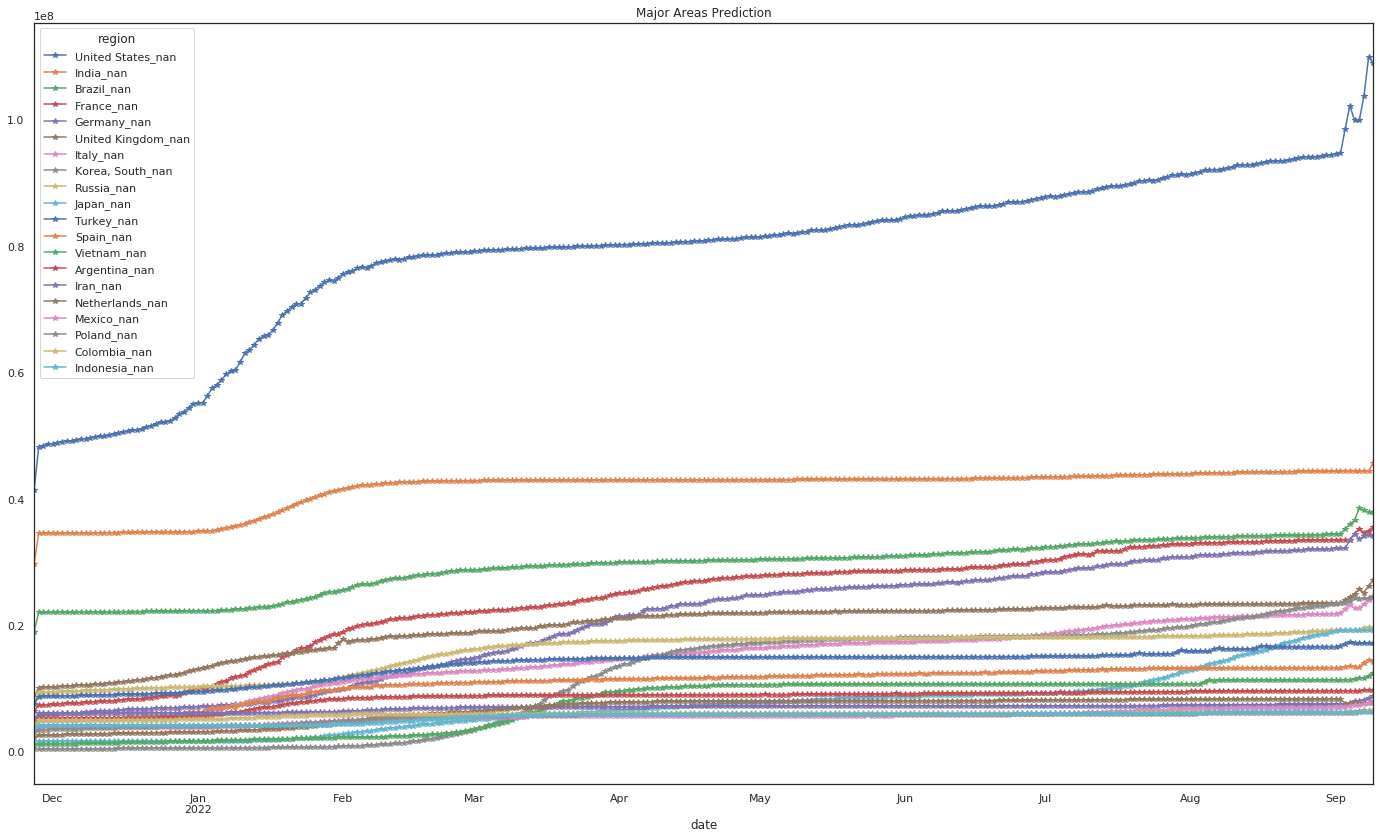

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

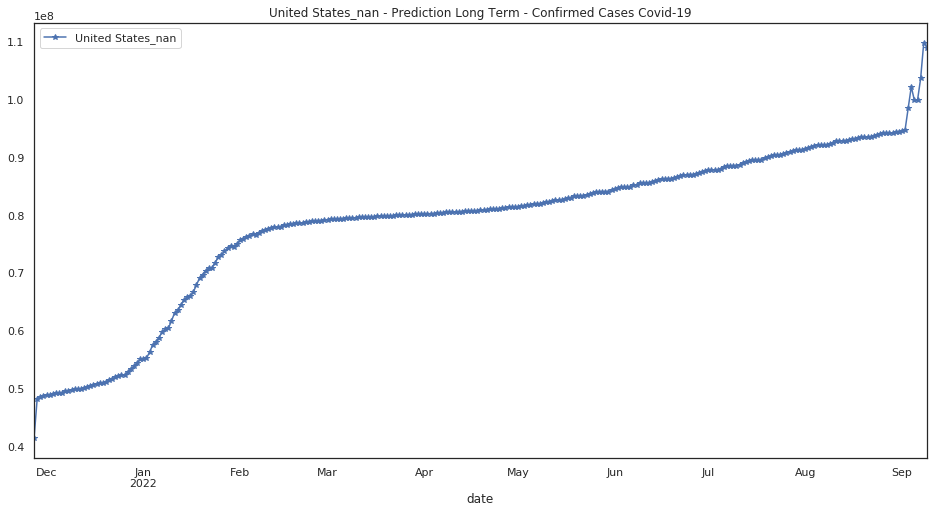

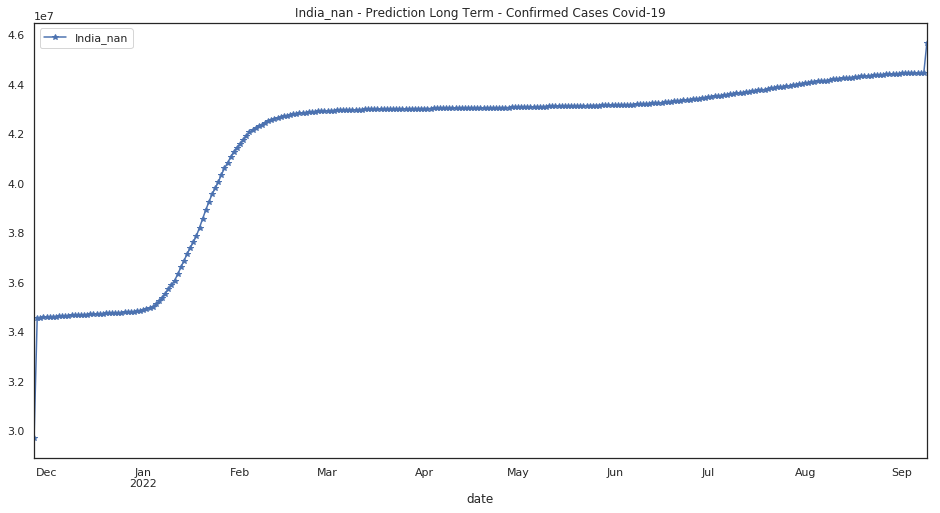

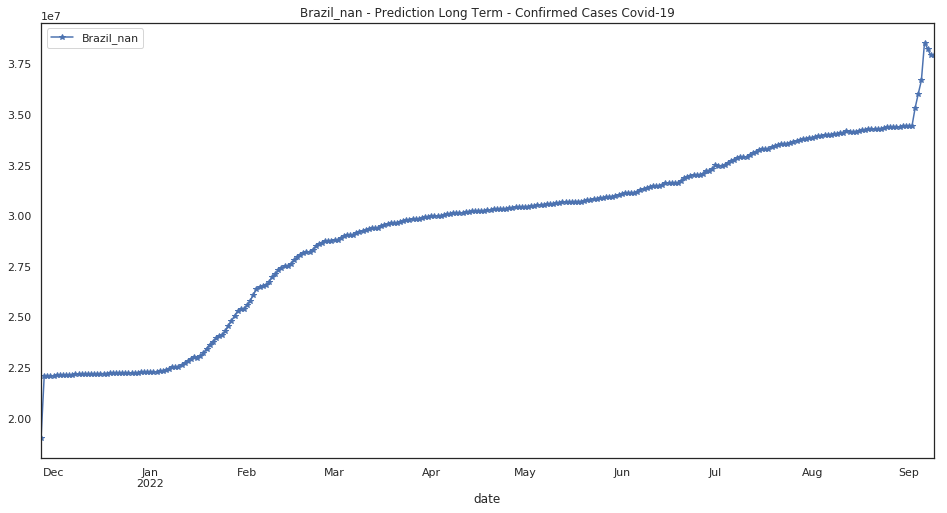

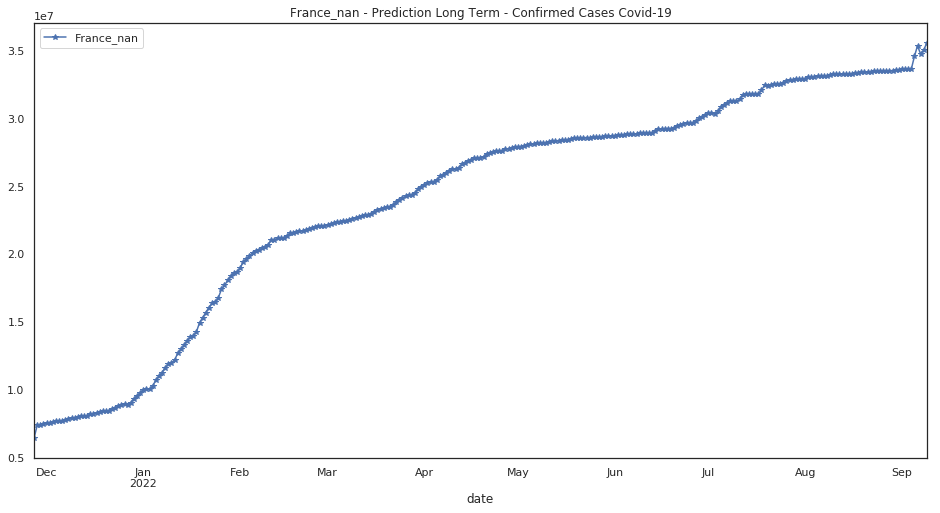

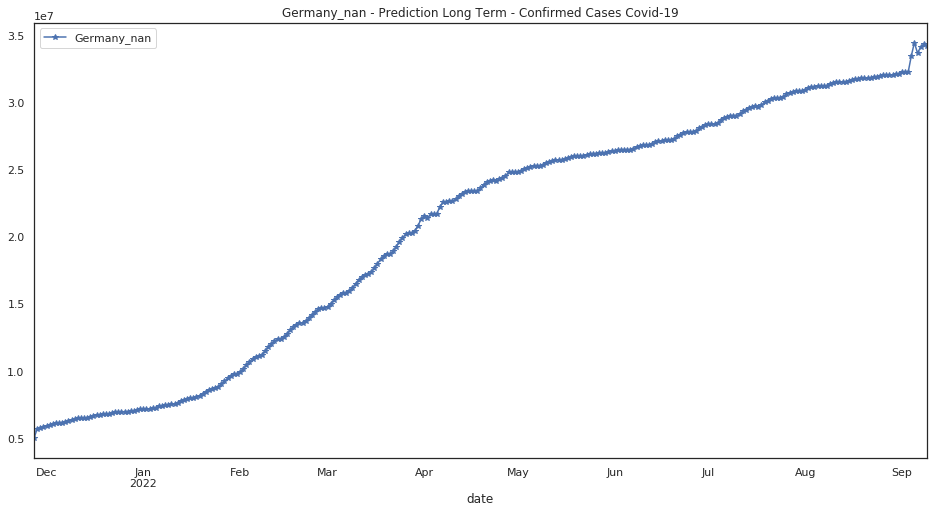

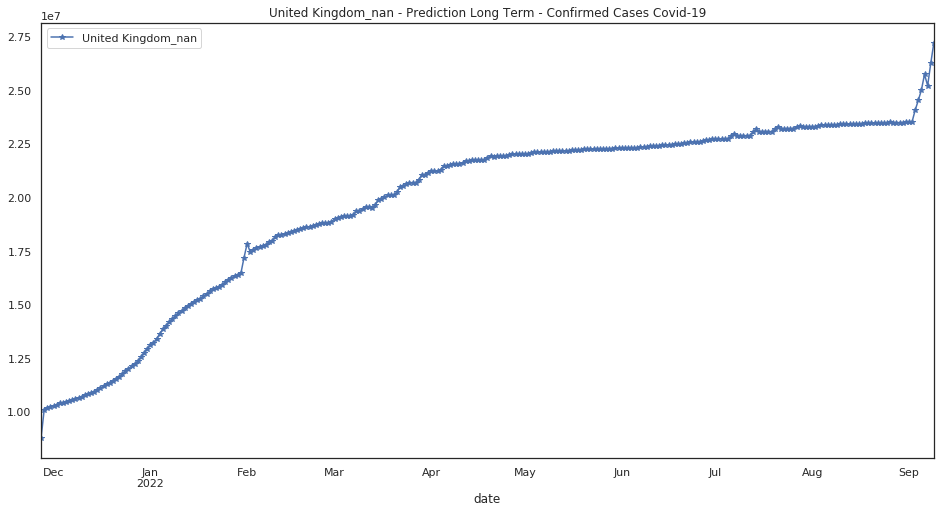

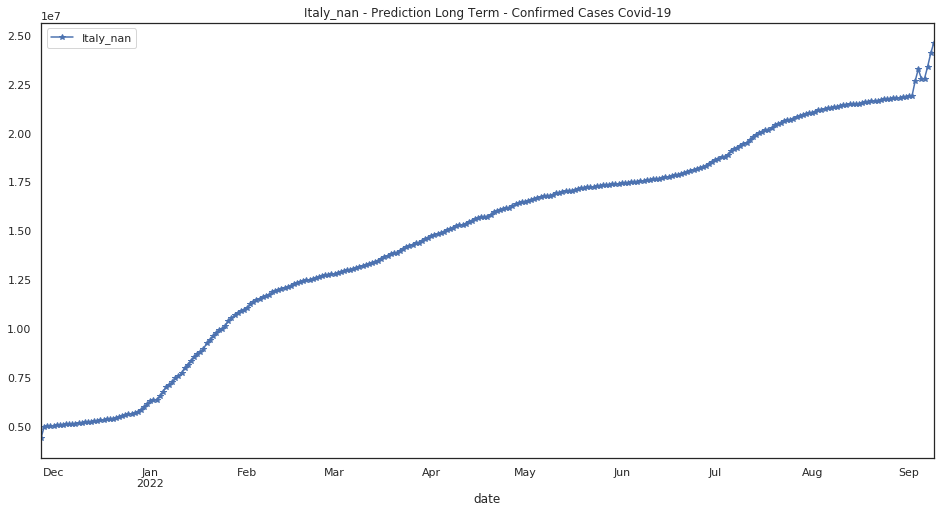

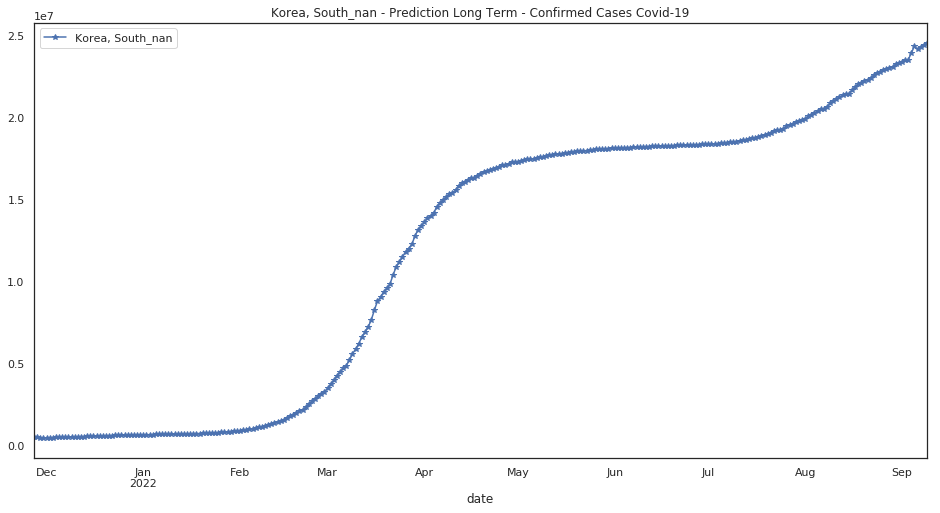

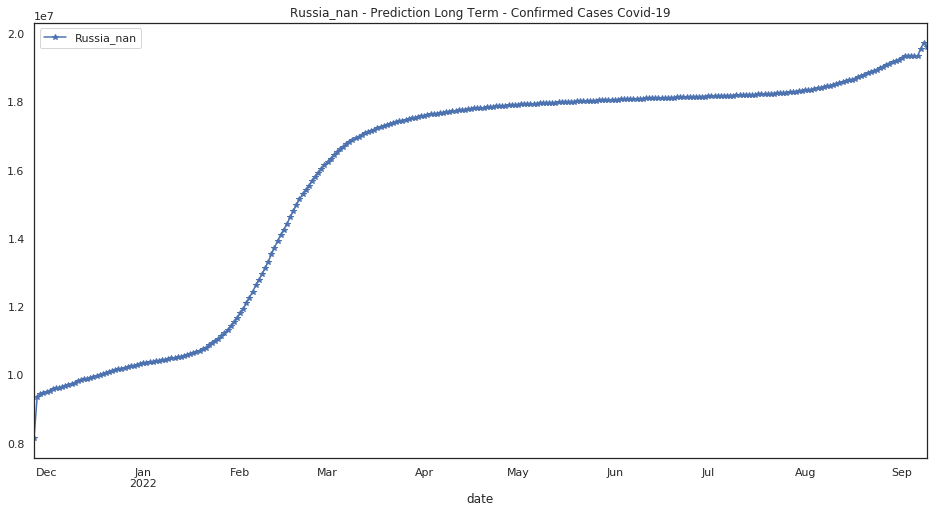

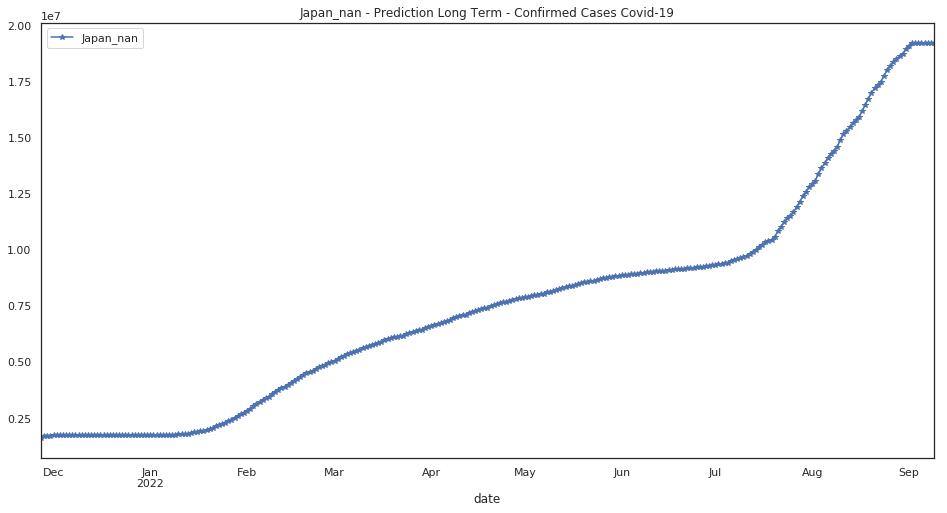

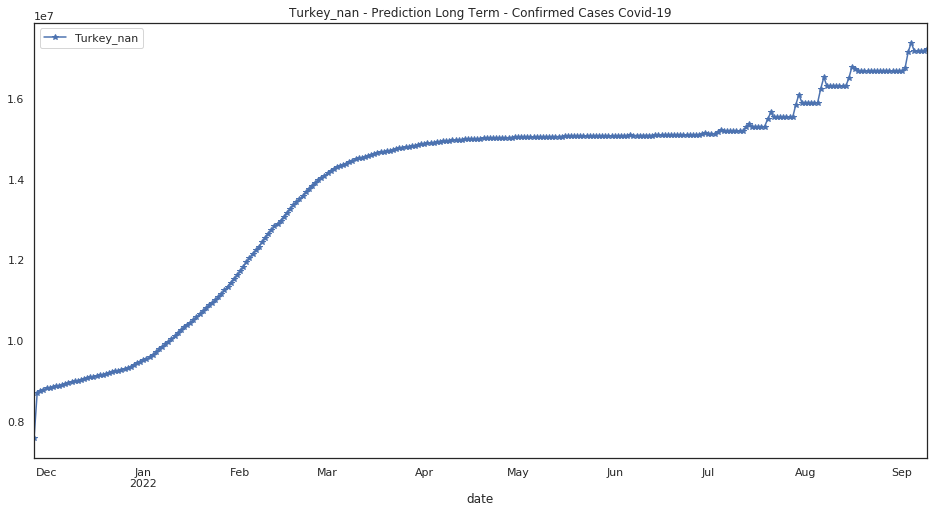

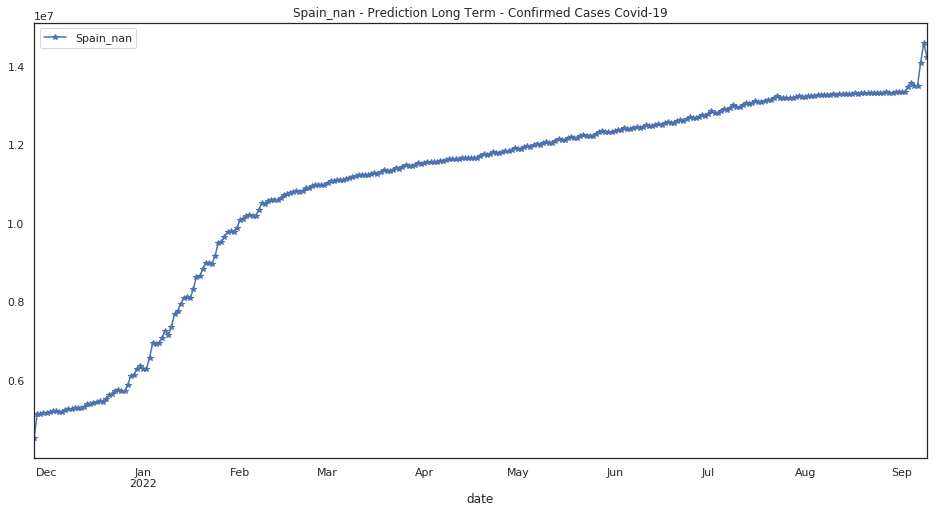

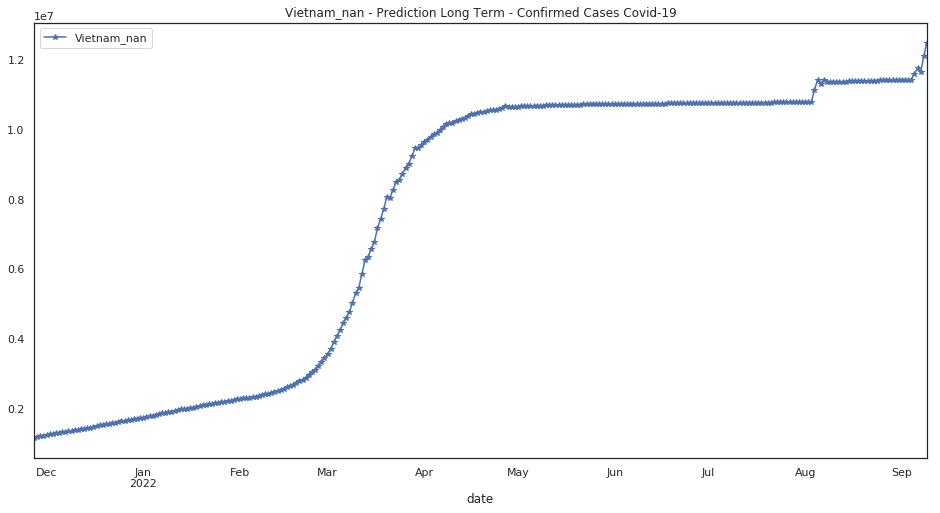

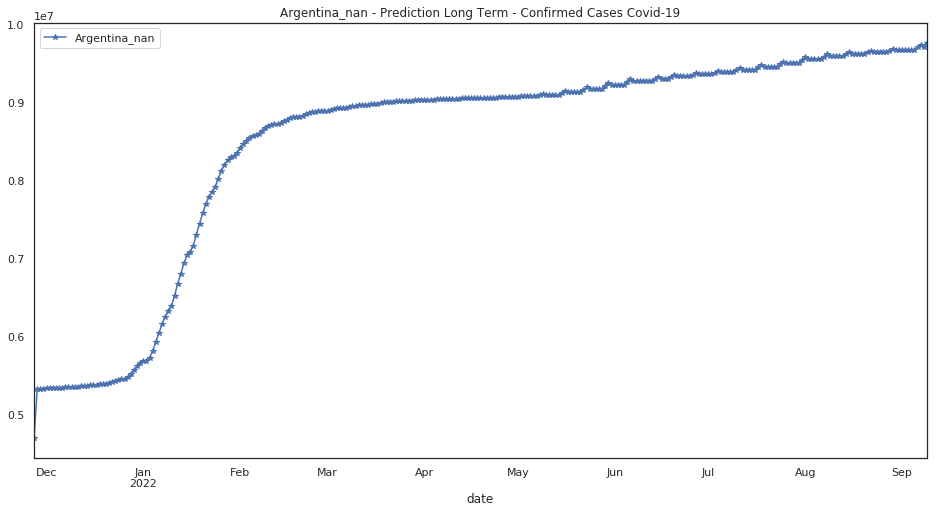

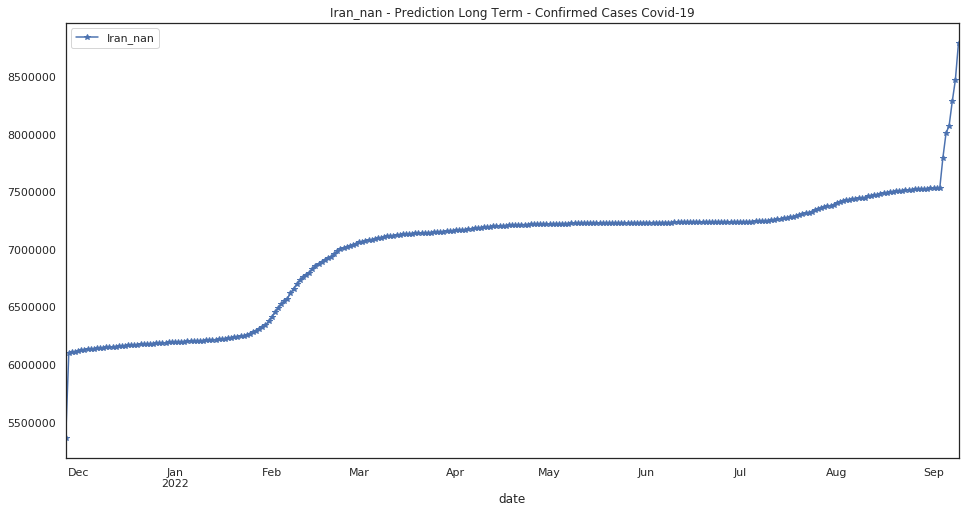

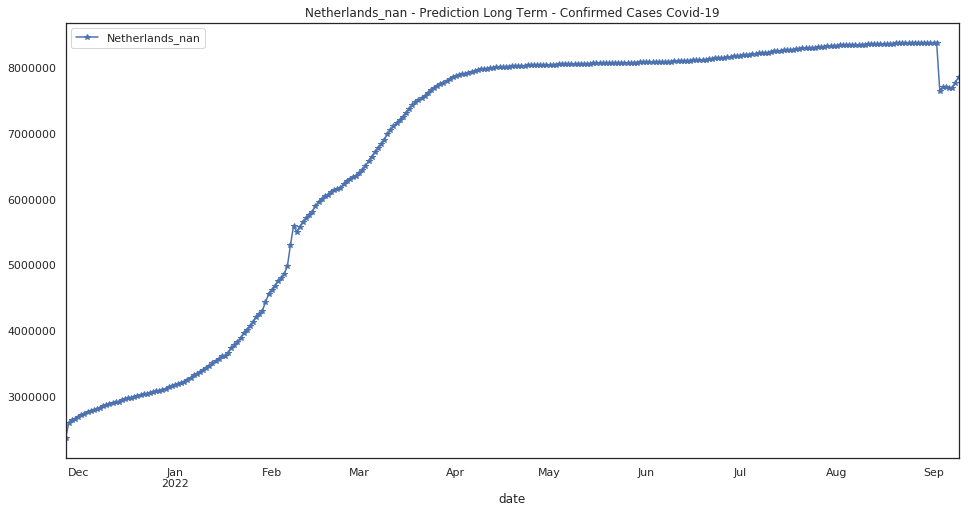

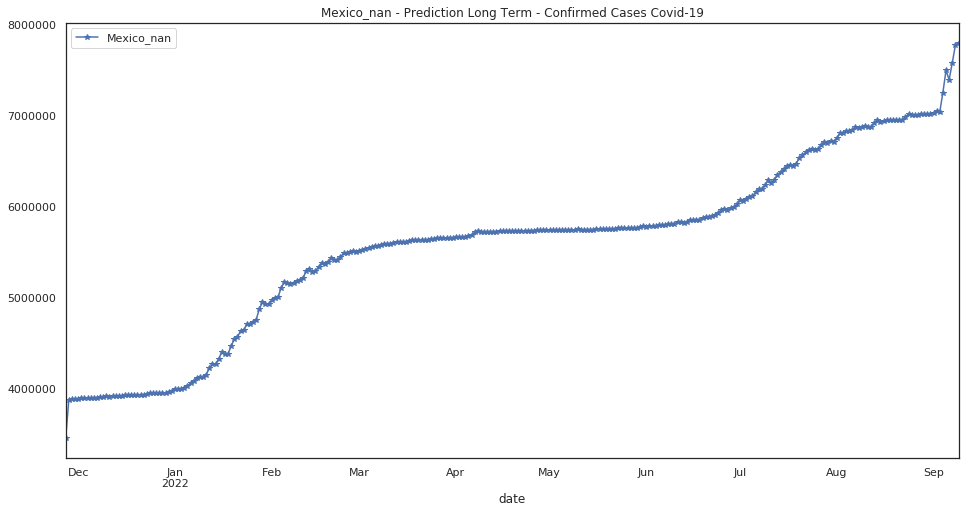

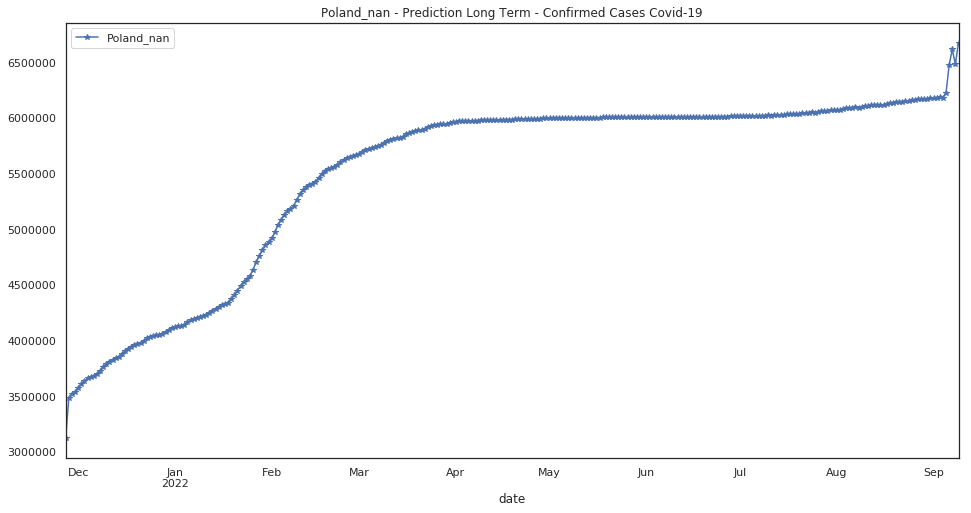

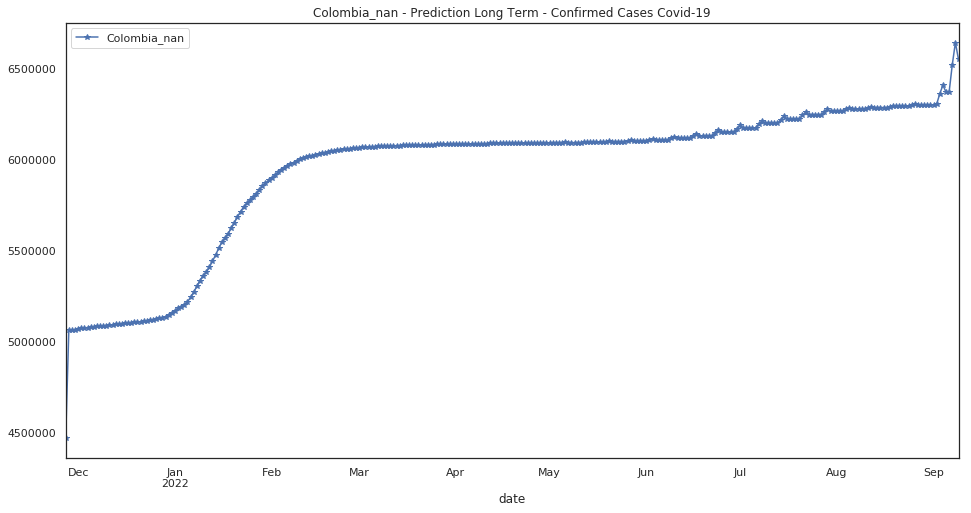

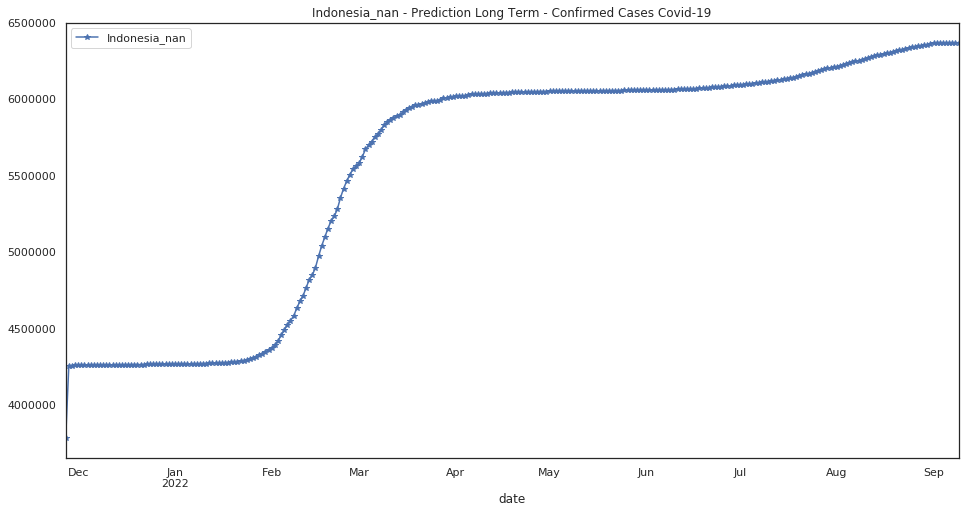

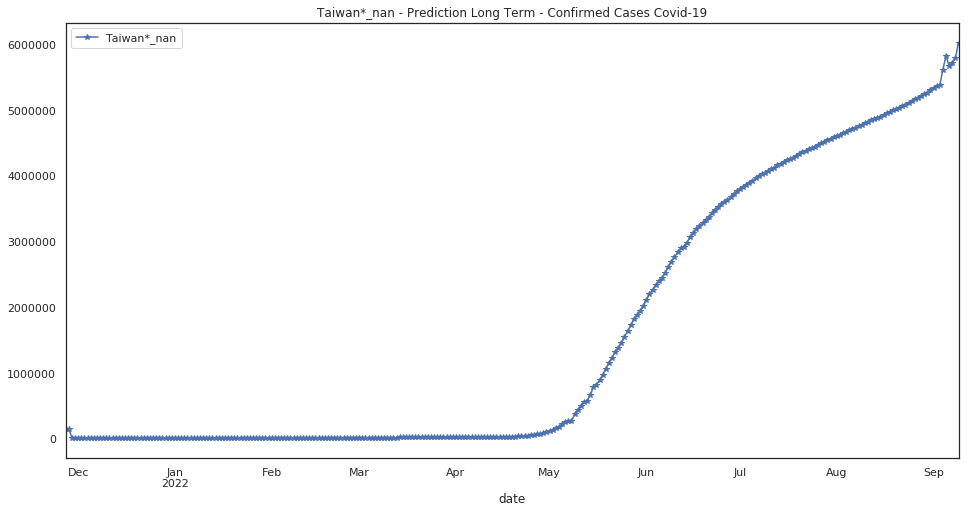

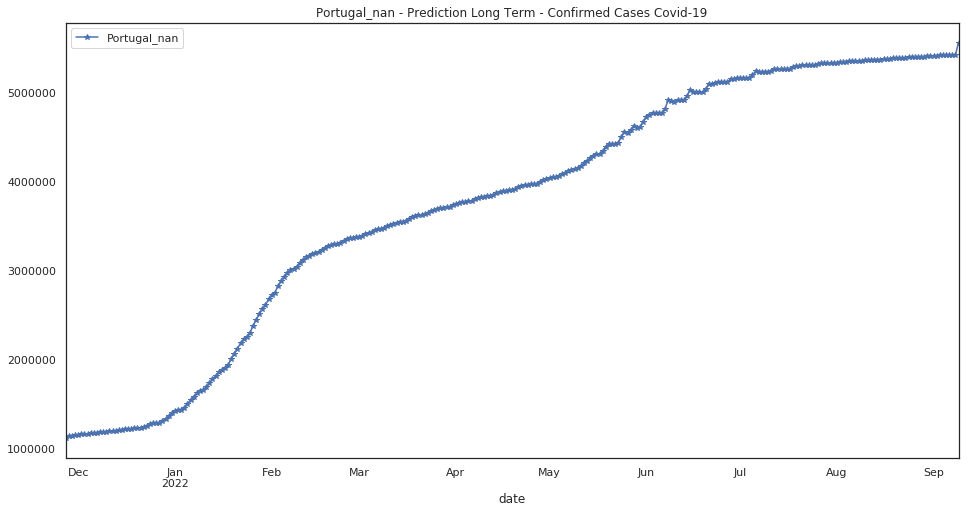

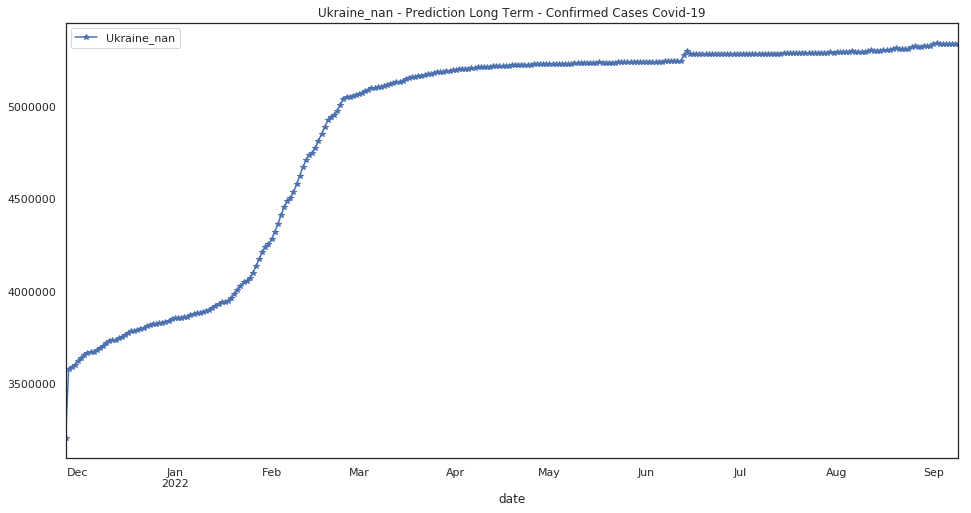

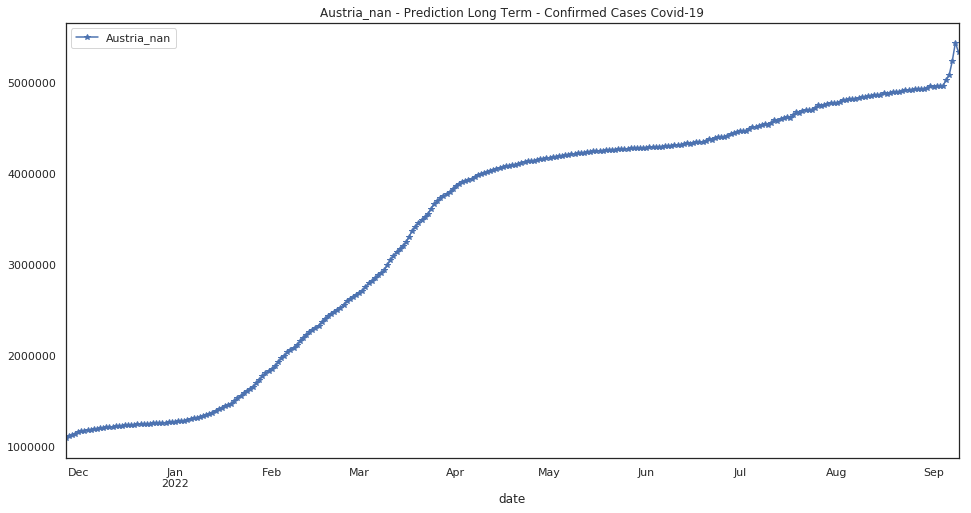

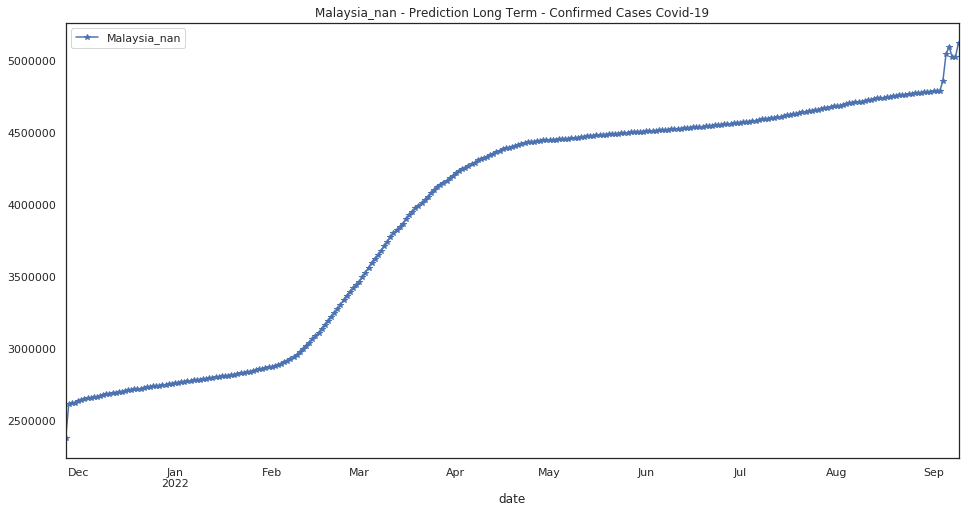

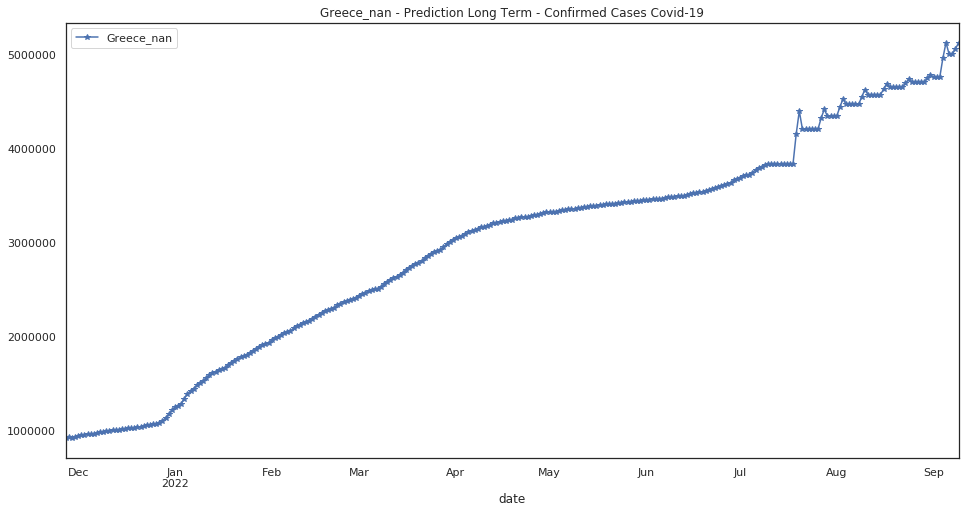

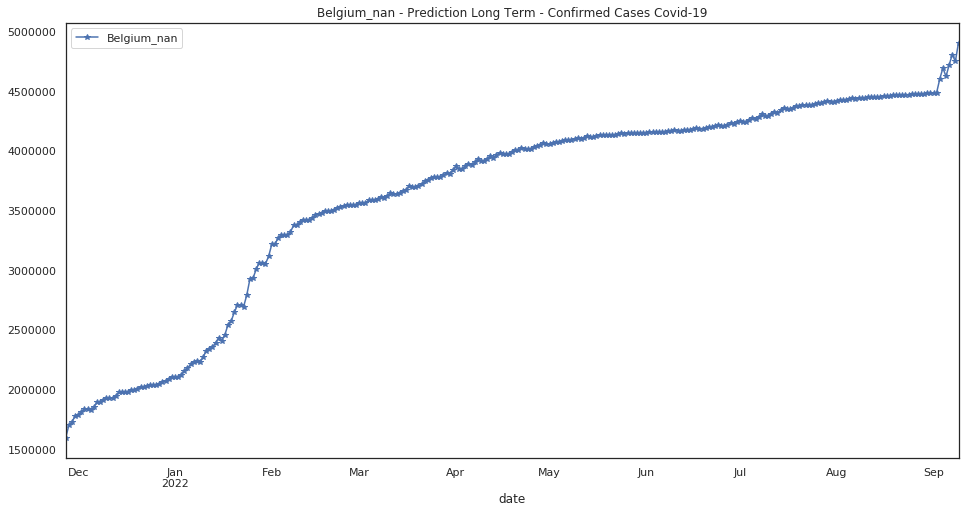

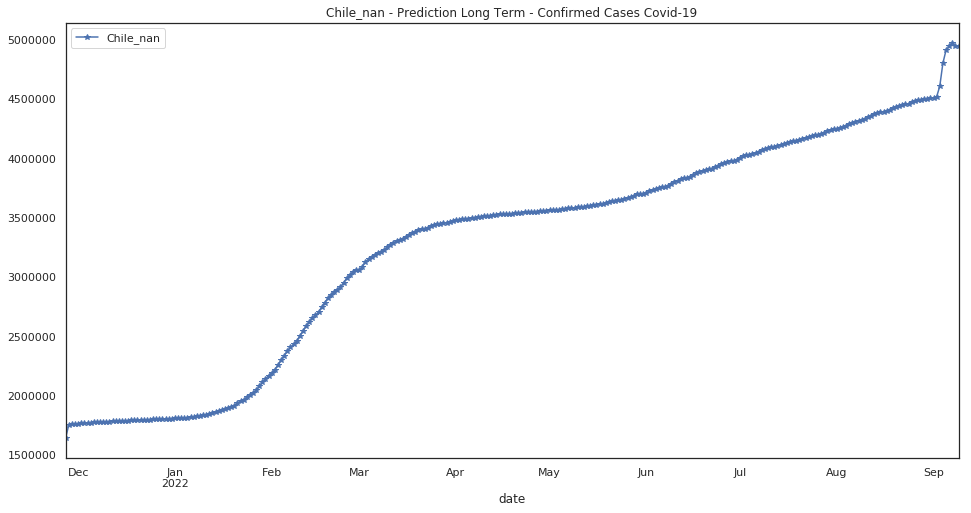

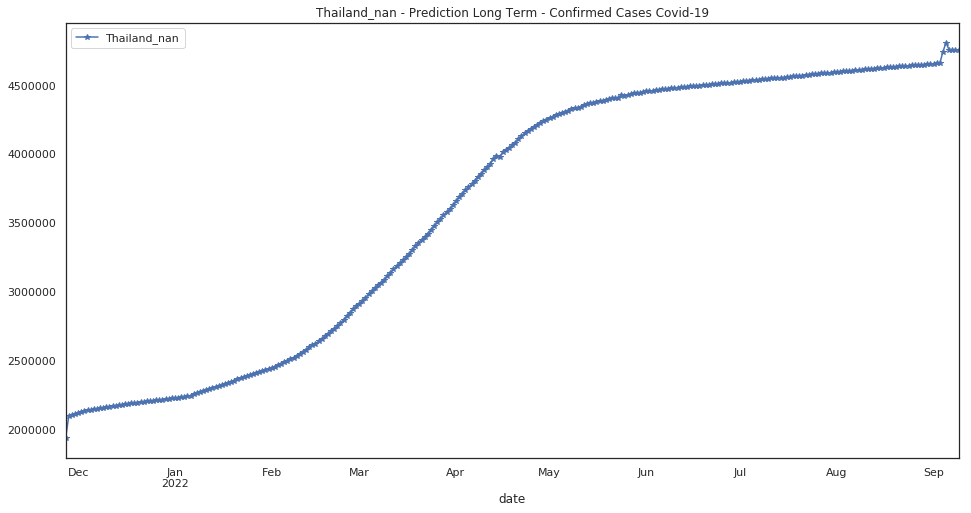

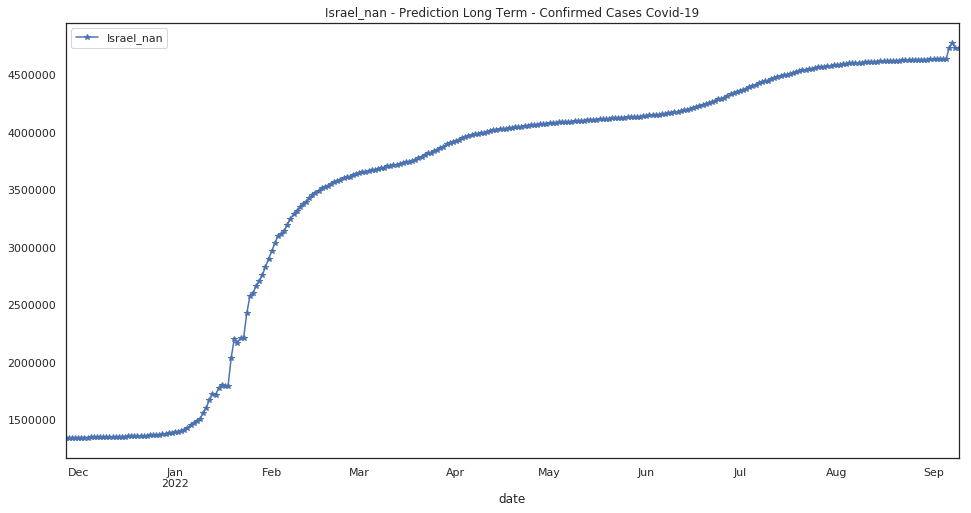

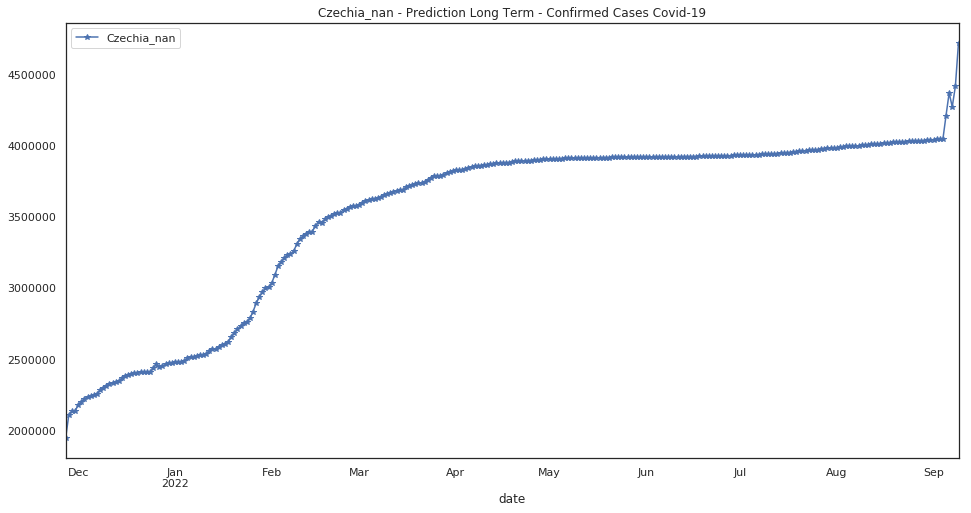

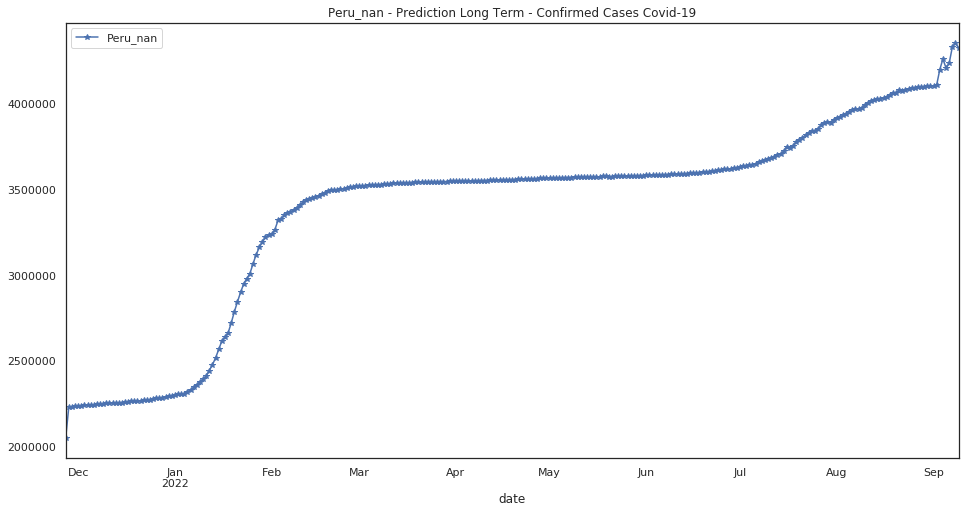

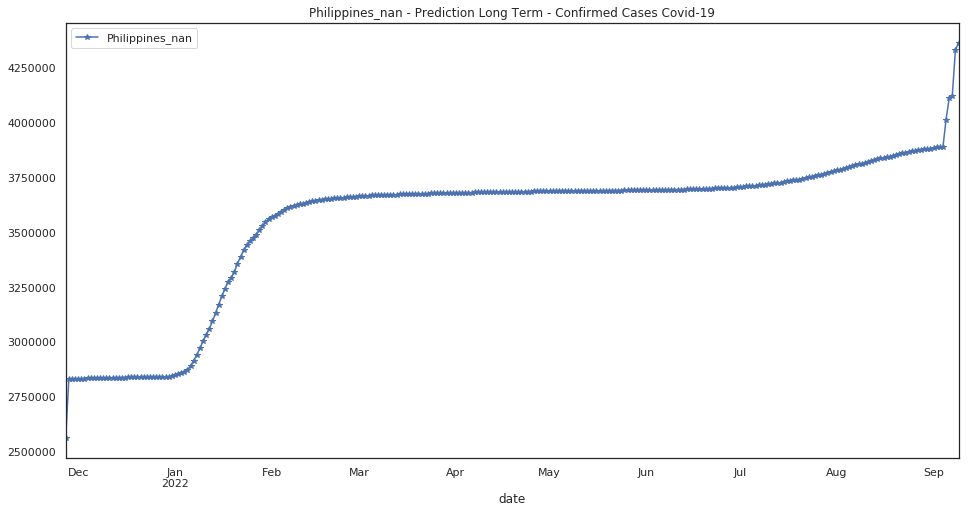

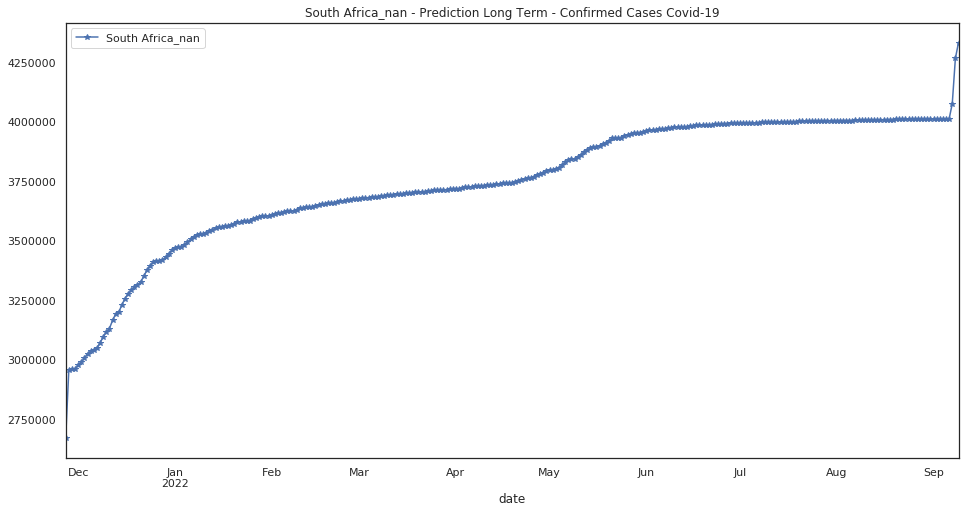

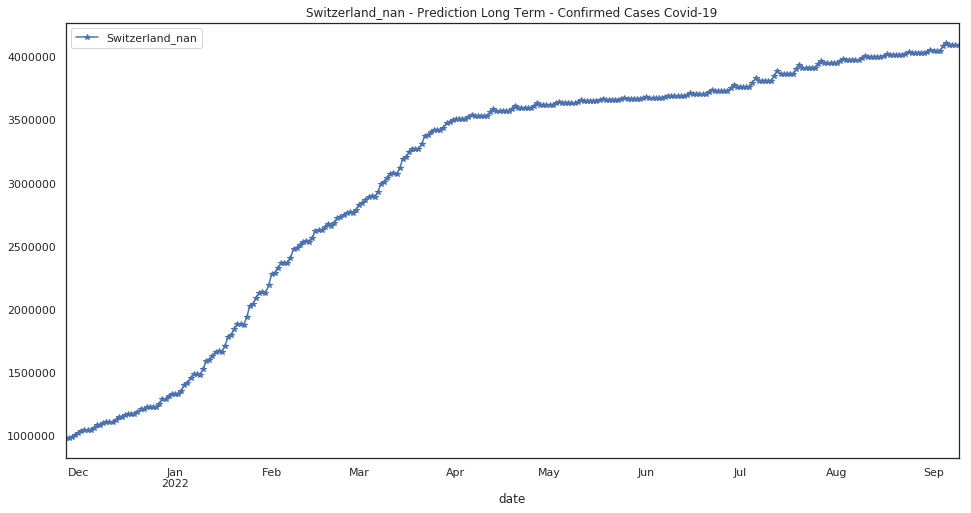

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

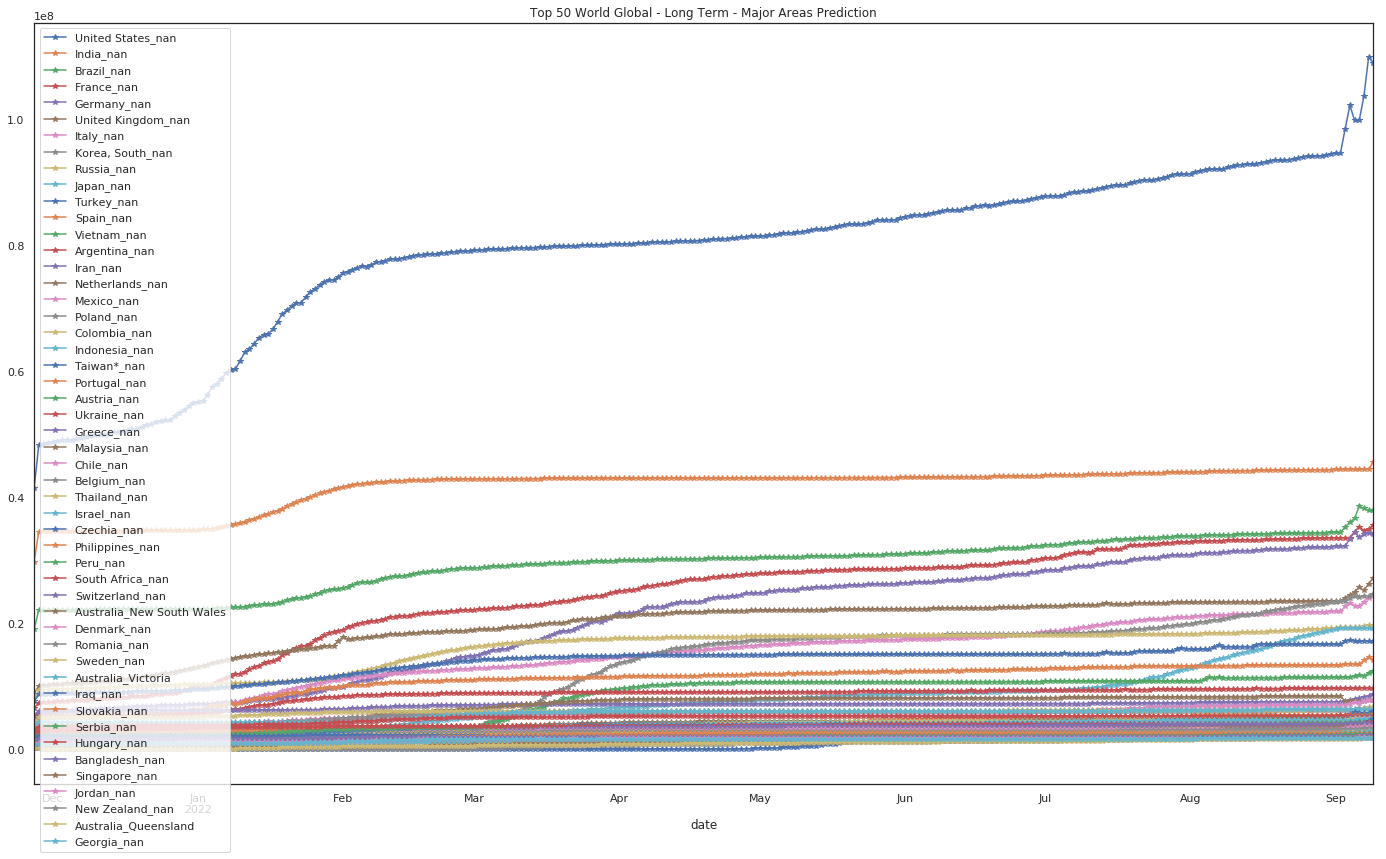

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

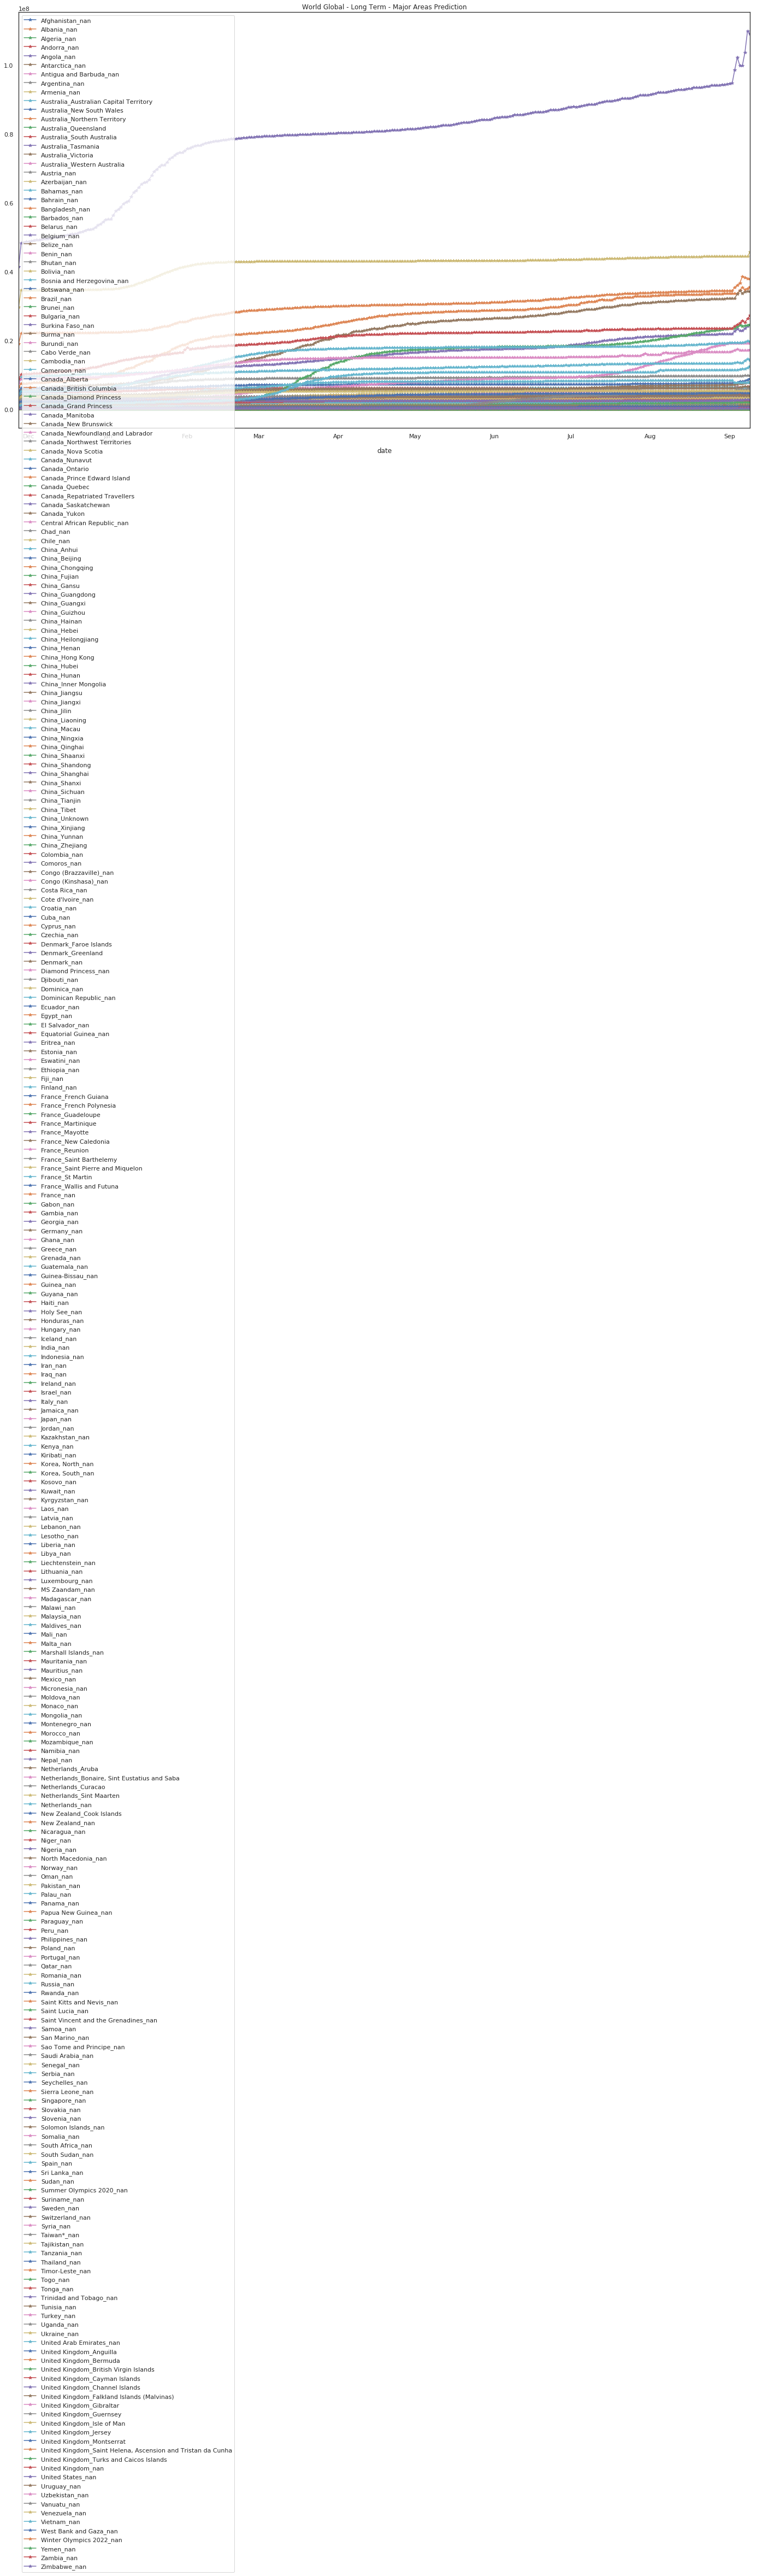

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2022-01-11         160583.0     223595.0     225082.0      27983.0   
2022-01-12         160609.0     225492.0     225679.0      28542.0   
2022-01-13         160703.0     227310.0     226257.0      28899.0   
2022-01-14         160732.0     229464.0     226846.0      29710.0   
2022-01-15         160785.0     231599.0     227359.0      29888.0   
2022-01-16         160822.0     233254.0     227918.0      29888.0   
2022-01-17         160920.0     234544.0     228582.0      29888.0   
2022-01-18         161039.0     237072.0     229363.0      29888.0   
2022-01-19         161132.0     239712.0     230636.0      29888.0   
2022-01-20         161362.0     242131.0     232132.0      31408.0   
2022-01-21         161534.0     244788.0     233916.0      32201.0   
2022-01-22         161592.0     247056.0     236039.0      33025.0   
2022-01-23         161736.0     248778.0     238118.0      33327.0   
2022-01-24         161930.0     248986.0     240261.0      33025.0   
2022-01-25         162221.0     249591.0     242671.0      33697.0   
2022-01-26         162621.0     251649.0     244808.0      34701.0   
2022-01-27         162926.0     253382.0     246904.0      35028.0   
2022-01-28         163054.0     255006.0     248783.0      35146.0   
2022-01-29         163331.0     255315.0     250523.0      35556.0   
2022-01-30         163993.0     256696.0     252043.0      35556.0   
2022-01-31         164622.0     259403.0     253417.0      35556.0   
2022-02-01         165291.0     259739.0     254844.0      35958.0   
2022-02-02         165987.0     261946.0     256274.0      35958.0   
2022-02-03         166518.0     262482.0     257329.0      36315.0   
2022-02-04         167137.0     263992.0     258335.0      36470.0   
2022-02-05         167474.0     264419.0     259195.0      36599.0   
2022-02-06         167992.0     265465.0     259664.0      36599.0   
2022-02-07         168670.0     266032.0     260173.0      36599.0   
2022-02-08         169416.0     266810.0     260811.0      36808.0   
2022-02-09         170221.0     267543.0     261447.0      36808.0   
...                     ...          ...          ...          ...   
2022-08-11         190479.0     321261.0     270772.0      45899.0   
2022-08-12         190684.0     321936.0     270921.0      45899.0   
2022-08-13         190833.0     322529.0     271064.0      45899.0   
2022-08-14         191048.0     322991.0     271197.0      45899.0   
2022-08-15         191321.0     323314.0     271324.0      45899.0   
2022-08-16         191468.0     323929.0     271436.0      45899.0   
2022-08-17         191722.0     324496.0     271529.0      45899.0   
2022-08-18         191997.0     325003.0     271611.0      45975.0   
2022-08-19         192239.0     326316.0     271705.0      45975.0   
2022-08-20         192440.0     327063.0     271791.0      45975.0   
2022-08-21         192648.0     327269.0     271869.0      45975.0   
2022-08-22         193011.0     327382.0     271958.0      45975.0   
2022-08-23         193218.0     327863.0     272040.0      45975.0   
2022-08-24         193563.0     328428.0     272114.0      45975.0   
2022-08-25         193918.0     328785.0     272171.0      46027.0   
2022-08-26         193962.0     329144.0     272219.0      46027.0   
2022-08-27         194023.0     329538.0     272253.0      46027.0   
2022-08-28         194444.0     329775.0     272275.0      46027.0   
2022-08-29         194811.0     329836.0     272314.0      46027.0   
2022-08-30         194983.0     330194.0     272356.0      46027.0   
2022-08-31         195266.0     330627.0     272391.0      46027.0   
2022-09-01         195507.0     330888.0     272445.0      46027.0   
2022-09-02         195542.0     331134.0     272494.0      46027.0   
2022-09-03         195576.0     332503.0     272500.0      46027.0   
2022-09-04

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
261                                        Tunisia_nan  33.886917    9.537499   
262                                         Turkey_nan  38.963700   35.243300   
263                                  United States_nan  40.000000 -100.000000   
264                                         Uganda_nan   1.373333   32.290275   
265                                        Ukraine_nan  48.379400   31.165600   
266                           United Arab Emirates_nan  23.424076   53.847818   
267                            United Kingdom_Anguilla  18.220600  -63.068600   
268                             United Kingdom_Bermuda  32.307800  -64.750500   
269              United Kingdom_British Virgin Islands  18.420700  -64.640000   
270                      United Kingdom_Cayman Islands  19.313300  -81.254600   
271                     United Kingdom_Channel Islands  49.372300   -2.364400   
272         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
273                           United Kingdom_Gibraltar  36.140800   -5.353600   
274                            United Kingdom_Guernsey  49.448196   -2.589490   
275                         United Kingdom_Isle of Man  54.236100   -4.548100   
276                              United Kingdom_Jersey  49.213800   -2.135800   
277                          United Kingdom_Montserrat  16.742498  -62.187366   
278  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      12       Australia_Queensland -27.469800  153.025100   
3      15         Australia_Victoria -37.813600  144.963100   
4      17                Austria_nan  47.516200   14.550100   
5      21             Bangladesh_nan  23.685000   90.356300   
6      24                Belgium_nan  50.833300    4.469936   
7      31                 Brazil_nan -14.235000  -51.925300   
8      60                  Chile_nan -35.675100  -71.543000   
9      95               Colombia_nan   4.570900  -74.297300   
10    104                Czechia_nan  49.817500   15.473000   
11    107                Denmark_nan  56.263900    9.501800   
12    133                 France_nan  46.227600    2.213700   
13    136                Georgia_nan  42.315400   43.356900   
14    137                Georgia_nan  42.315400   43.356900   
15    138                Germany_nan  51.165691   10.451526   
16    140                 Greece_nan  39.074200   21.824300   
17    150                Hungary_nan  47.162500   19.503300   
18    152                  India_nan  20.593684   78.962880   
19    153              Indonesia_nan  -0.789300  113.921300   
20    154                   Iran_nan  32.427908   53.688046   
21    155                   Iraq_nan  33.223191   43.679291   
22    157                 Israel_nan  31.046051   34.851612   
23    158                 Israel_nan  31.046051   34.851612   
24    159                  Italy_nan  41.871940   12.567380   
25    161                  Japan_nan  36.204824  138.252924   
26    162                 Jordan_nan  31.240000   36.510000   
27    167           Korea, South_nan  35.907757  127.766922   
28    184               Malaysia_nan   4.210484  101.975766   
29    191                 Mexico_nan  23.634500 -102.552800   
30    205            Netherlands_nan  52.132600    5.291300   
31    207            New Zealand_nan -40.900600  174.886000   
32    219                   Peru_nan  -9.190000  -75.015200   
33    220            Philippines_nan  12.879721  121.774017   
34    221                 Poland_nan  51.919400   19.145100   
35    222               Portugal_nan  39.399900   -8.224500   
36    224                Romania_nan  45.943200   24.966800   
37    225                 Russia_nan  61.524010  105.318756   
38    235                 Serbia_nan  44.016500   21.005900   
39    238              Singapore_nan   1.283300  103.833300   
40    239               Slovakia_nan  48.669000   19.699000   
41    243           South Africa_nan -30.559500   22.937500   
42    245                  Spain_nan  40.463667   -3.749220   
43    250                 Sweden_nan  60.128161   18.643501   
44    251            Switzerland_nan  46.818200    8.227500   
45    253                Taiwan*_nan  23.700000  121.000000   
46    256               Thailand_nan  15.870032  100.992541   
47    262                 Turkey_nan  38.963700   35.243300   
48    263          United States_nan  40.000000 -100.000000   
49    265                Ukraine_nan  48.379400   31.165600   
50    280         United Kingdom_nan  55.378100   -3.436000   
51    285                Vietnam_nan  14.058324  108.277199   

    2021-11-27 00:00:00  2021-11-28 00:00:00  2021-11-29 00:00:00  \
0             4697763.0            5325560.0            5326448.0   
1              210593.0             210716.0              81499.0   
2              142796.0             142800.0               2125.0   
3              243501.0             244356.0             120814.0   
4             1097810.0            1118256.0            1133639.0   
5             1489116.0            1575579.0            1575784.0   
6             1596973.0            1701633.0            1731343.0   
7            19035161.0           22081833.0           22085369.0   
8             1644414.0            1757077.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()

In [94]:
num_days_R_prediction=14
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)
print(str(ndaysavg)+' '+str(ndayarray)+' '+str(n2dayarray))

14 -15 -29
